In [3]:
import tables
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from ctapipe.image import tailcuts_clean
from scipy.interpolate import griddata
from astropy import units as u
import numpy as np

In [4]:
data_path = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data = tables.open_file(data_path)

# acquire the data
data_ainfo = data.root.Array_Info
data_einfo = data.root.Event_Info
data_LST = data.root.LST

print(repr(data_ainfo))
print(repr(data_einfo))
print(repr(data_LST))

# array info data
ai_run_array_direction = [x['run_array_direction']
                          for x in data_ainfo.iterrows()]
ai_tel_id = [x['tel_id'] for x in data_ainfo.iterrows()]
ai_tel_type = [x['tel_type'] for x in data_ainfo.iterrows()]
ai_tel_x = [x['tel_x'] for x in data_ainfo.iterrows()]
ai_tel_y = [x['tel_y'] for x in data_ainfo.iterrows()]
ai_tel_z = [x['tel_z'] for x in data_ainfo.iterrows()]

# event info data
ei_alt = [x['alt'] for x in data_einfo.iterrows()]
ei_az = [x['az'] for x in data_einfo.iterrows()]
ei_core_x = [x['core_x'] for x in data_einfo.iterrows()]
ei_core_y = [x['core_y'] for x in data_einfo.iterrows()]
ei_event_number = [x['event_number'] for x in data_einfo.iterrows()]
ei_h_first_int = [x['h_first_int'] for x in data_einfo.iterrows()]
ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
ei_particle_id = [x['particle_id'] for x in data_einfo.iterrows()]
ei_run_number = [x['run_number'] for x in data_einfo.iterrows()]
ei_LST_indices = [x['LST_indices'] for x in data_einfo.iterrows()]

# LST data
LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)
/Event_Info (Table(5038,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(sha

In [8]:
#e_idx = 58 , 674
# e_idx = 2229
# select a spcific event
my_event = data_einfo[e_idx]
print('Event number: {}'.format(my_event['event_number']))
print('Energy: {} TeV'.format(my_event['mc_energy']))
print('Alt: {} rad'.format(my_event['alt']))
print('Az: {} rad'.format(my_event['az']))
my_indices = my_event['LST_indices']
print('LST_indices: ' + str(my_indices))

Event number: 1855003
Energy: 0.03583614528179169 TeV
Alt: 1.2217304706573486 rad
Az: 6.283185005187988 rad
LST_indices: [1401    0    0    0]


In [9]:
#we will take always the first lst index just for demostrations
# print event information
img_charge = LST_image_charge[my_indices[0]]
img_time = LST_image_peak_times[my_indices[0]]
print(img_charge)
print(img_time)

[-1.4669234  -0.12082262  1.4300067  ... -0.1607494  -1.0894396
 -0.7202792 ]
[20. 12. 21. ...  3. 19.  4.]


In [10]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

# plt.suptitle('EVENT')
disps = []

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)
clean = img_charge.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_charge
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)

grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(2, 1, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
#plt.savefig('real-interp.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

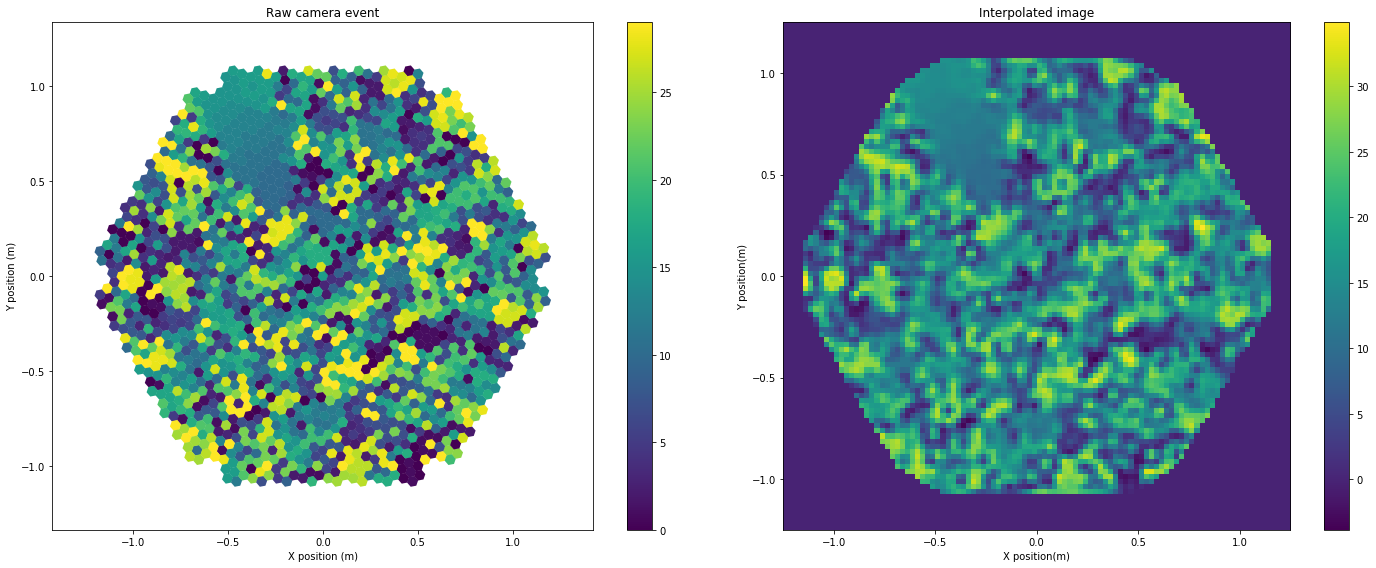

In [6]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

#plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_time, picture_thresh=10, boundary_thresh=5
)
clean = img_time.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_time
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)

#grid_x, grid_y = np.mgrid[-1.17:1.17:100j, -1.17:1.17:100j]
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="equal")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
plt.savefig('real-interp-time.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

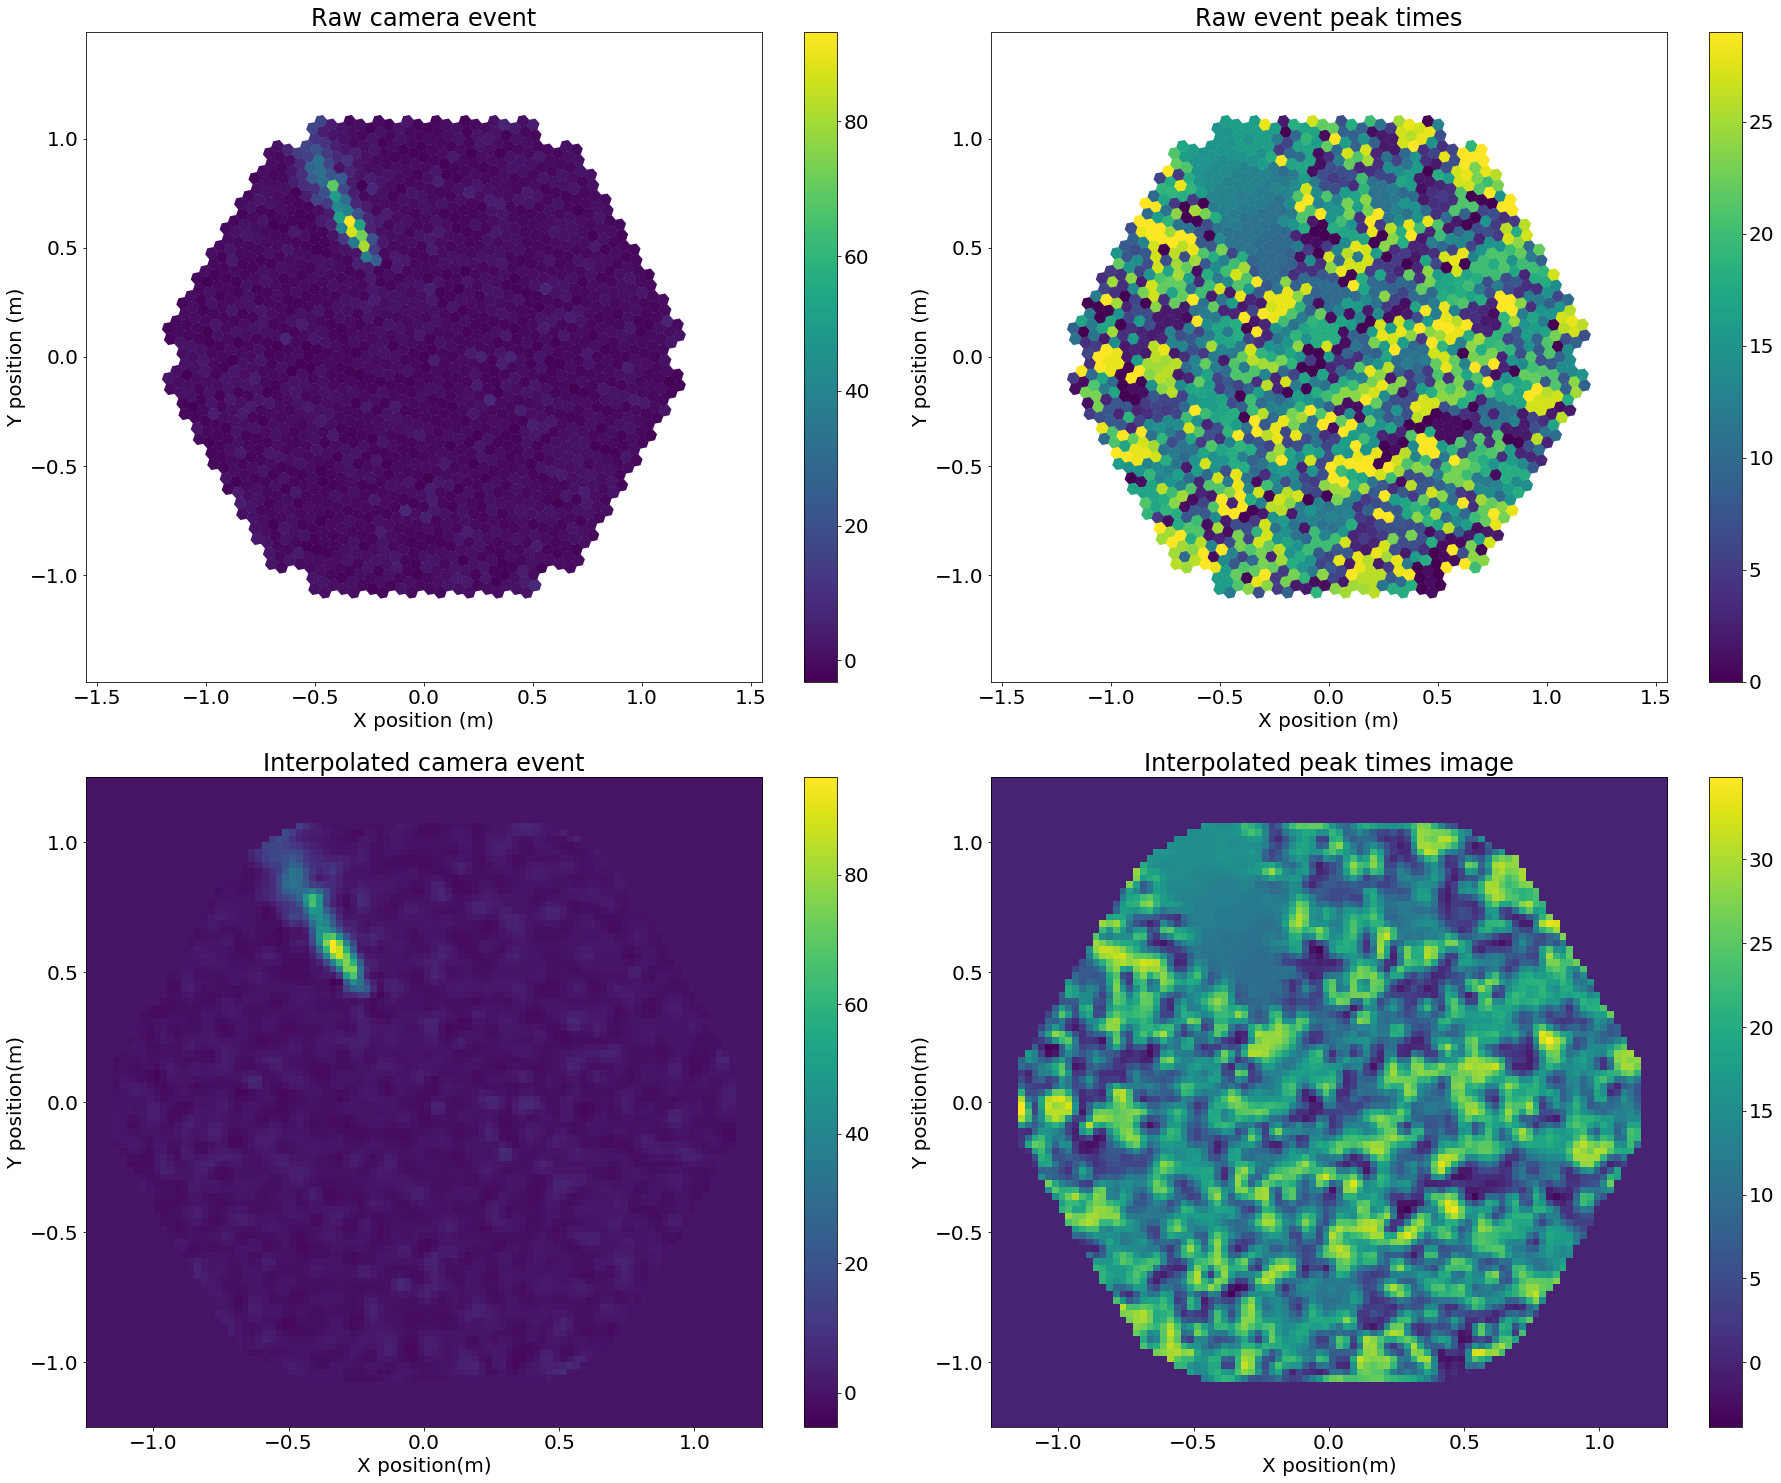

In [11]:
%matplotlib inline 
import matplotlib
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(26, 21))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_charge

ax = plt.subplot(2, 2, 3)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated camera event')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Raw event peak times")
disp.add_colorbar()
disp.image = img_time


ax = plt.subplot(2, 2, 4)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated peak times image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


plt.tight_layout()
plt.savefig('real-interp-4.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [12]:
print(100*100 - np.count_nonzero(grid_z))

3750


In [13]:
print(grid_z[99][:])
print(grid_z.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100, 100)


In [14]:
# hillas parameters

from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'axes.labelsize': 15})

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera image")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
# cleanmask = tailcuts_clean(
#    geom, img_charge, picture_thresh=10, boundary_thresh=5
#)

# Calculate image parameters
#hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
#disp.highlight_pixels(cleanmask, color='crimson')
#disp.overlay_moments(hillas, color='cyan', linewidth=3)

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

ax = plt.subplot(2, 1, 2)

disp = CameraDisplay(geom, ax=ax, title="Hillas parametrization")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)

# Calculate image parameters
hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
cleaned = img_charge.copy()
cleaned[~cleanmask] = 0.0
disp.image = cleaned
#disp.highlight_pixels(cleanmask, color='crimson')
disp.overlay_moments(hillas, color='cyan', linewidth=3)

print(hillas)

fig.tight_layout()
fig.savefig('raw_hillas.eps', format='eps', bbox_inches='tight')
plt.show()

{'intensity': 1408.6658382415771,
 'kurtosis': 2.0663543519750247,
 'length': <Quantity 0.17381068 m>,
 'phi': <Angle 2.06827824 rad>,
 'psi': <Angle -1.09110863 rad>,
 'r': <Quantity 0.79771159 m>,
 'skewness': -0.28098394031337504,
 'width': <Quantity 0.04199072 m>,
 'x': <Quantity -0.38067929 m>,
 'y': <Quantity 0.70101859 m>}


In [21]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import numpy as np
import matplotlib

data_path_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_gamdi = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun1000-5606___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5'
data_path_proto = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_gamdi = tables.open_file(data_path_gamdi)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_gamdi = data_gamdi.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_gamdi = data_gamdi.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_gamdi = [x['event_index'] for x in data_LST_gamdi.iterrows()]
LST_image_charge_gamdi = [x['image_charge'] for x in data_LST_gamdi.iterrows()]
LST_image_peak_times_gamdi = [x['image_peak_times'] for x in data_LST_gamdi.iterrows()]
ei_mc_energy_gamdi = [x['mc_energy'] for x in data_einfo_gamdi.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_gamdi = np.argsort(-np.array(ei_mc_energy_gamdi), axis=0)[10]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_gamdi)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_gamdi = data_einfo_gamdi[e_idx_gamdi]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_gamdi['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_gamdi = my_event_gamdi['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_gamdi)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_gamdi = LST_image_charge_gamdi[my_indices_gamdi[0]]
img_time_gamdi = LST_image_peak_times_gamdi[my_indices_gamdi[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
f = 2
fig = plt.figure(figsize=(36, 20))

ax = plt.subplot(2, 3, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 3, 2)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - charge")
disp.add_colorbar()
disp.image = img_charge_gamdi

ax = plt.subplot(2, 3, 3)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 3, 4)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 3, 5)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamdi

ax = plt.subplot(2, 3, 6)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

# matplotlib.rc('font', **font)

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

2356
117
474
Energy: 1.5281083583831787 TeV
Energy: 93.2811050415039 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[32 33 34 35]
[198   0   0 199]


2356
474
Energy: 1.5281083583831787 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[198   0   0 199]


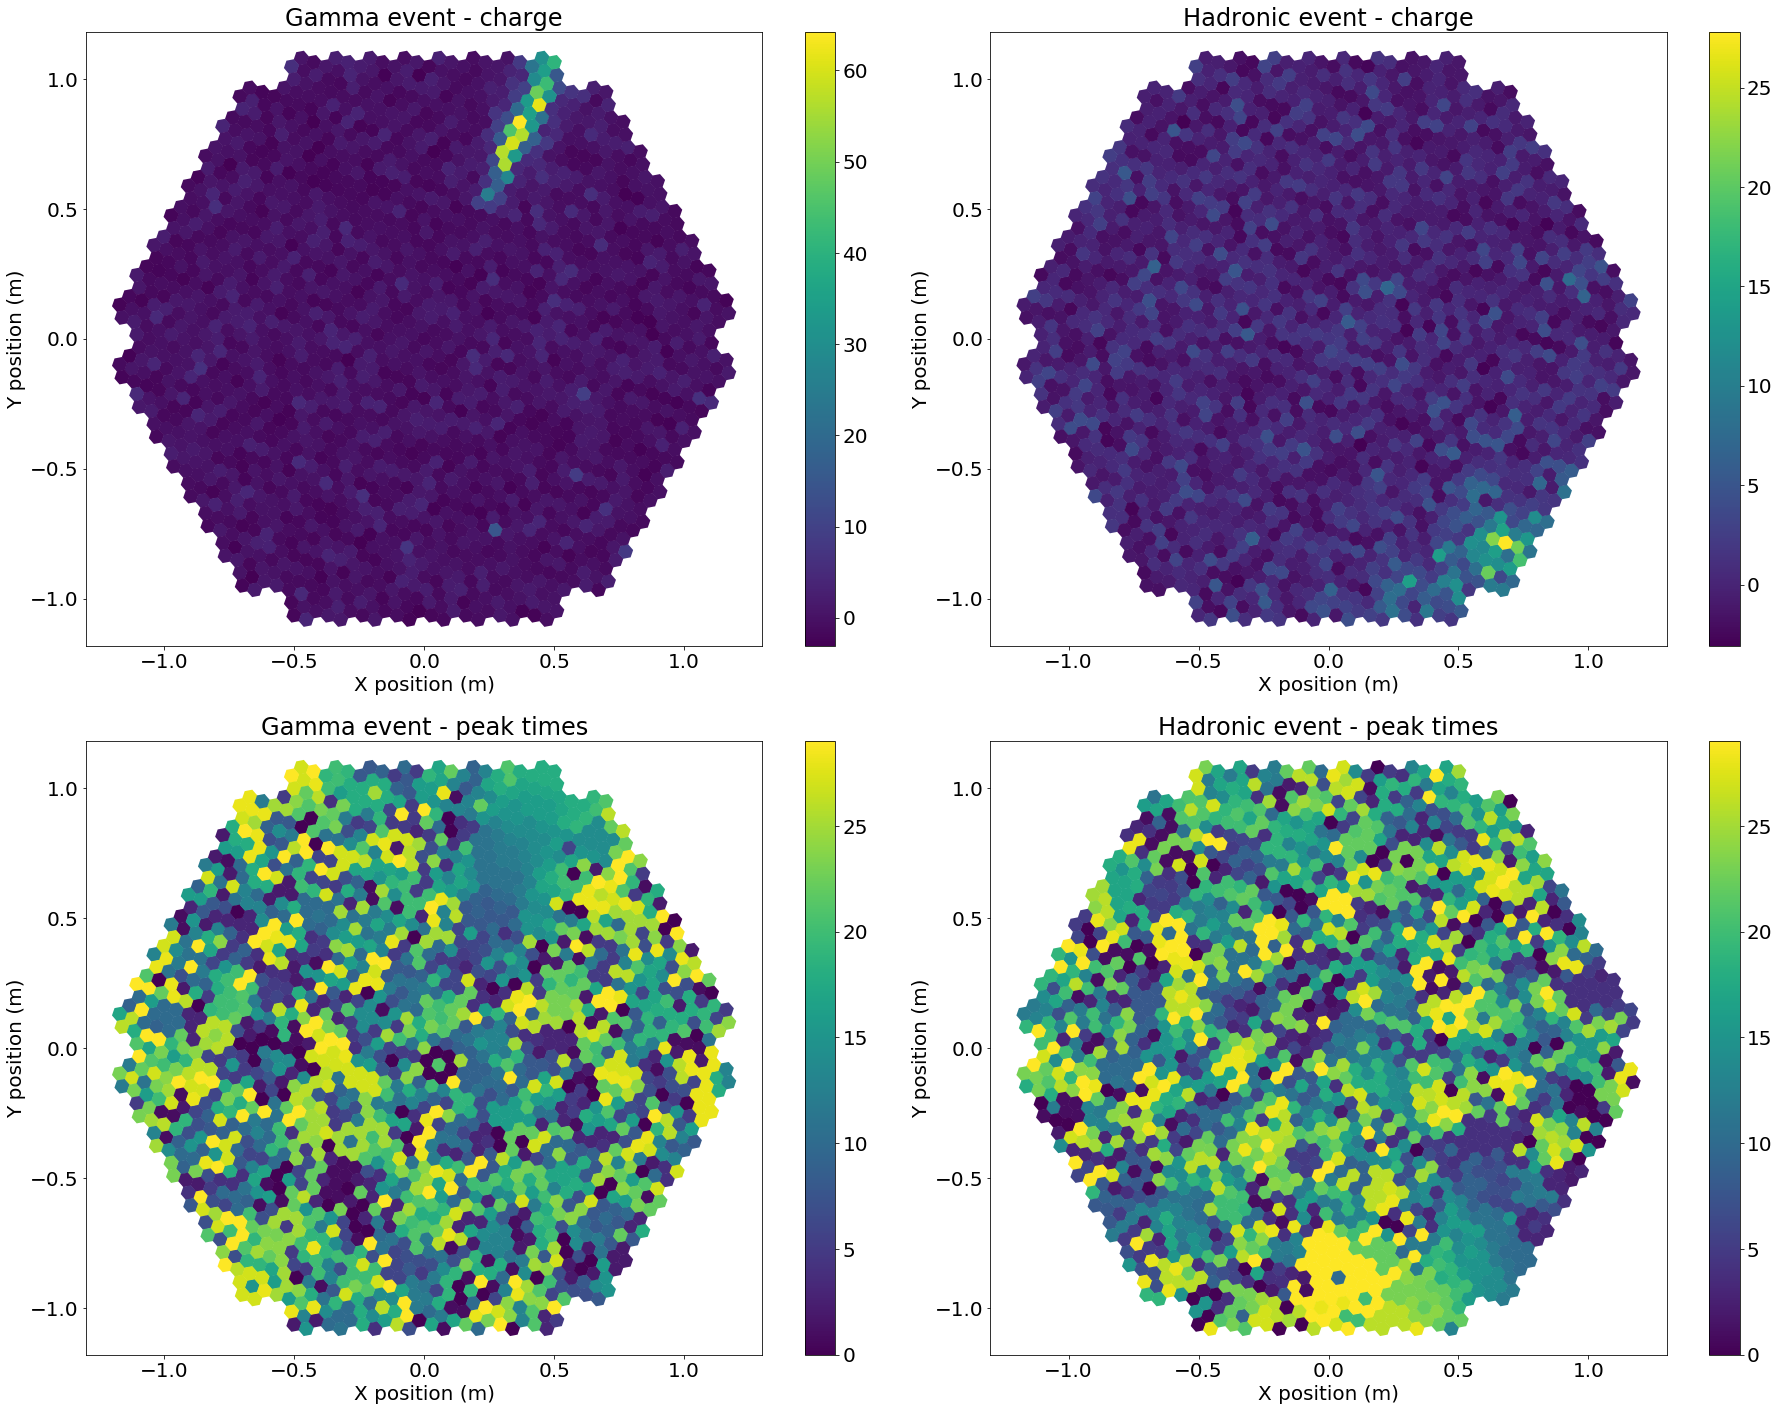

In [16]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import toymodel
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tables

data_path_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_proto = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135 or 553
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

'''
#overwrite with a toy model
# create a fake camera image to display:

model = toymodel.Gaussian(
    x=0.2 * u.m,
    y=0.0 * u.m,
    width=0.05 * u.m,
    length=0.15 * u.m,
    psi='35d',
)

img_charge_gamma, sig, bg = model.generate_image(geom, intensity=1500, nsb_level_pe=5)
'''

f = 2
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 2, 3)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - peak times")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 2, 4)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - peak times")
disp.add_colorbar()
disp.image = img_time_proto

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [24]:
# execute on VM with ipython
from keras.utils.data_utils import OrderedEnqueuer
from keras.utils.generic_utils import Progbar

from generators import DataGeneratorR
from utils import get_all_files
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib

def retrieve_energy(generator):
    # retrieve energy
    print('Retrieving ground truth...')
    gt_feature = []
    steps_done = 0
    steps = len(generator)

    enqueuer = OrderedEnqueuer(generator, use_multiprocessing=True)
    enqueuer.start(workers=24, max_queue_size=10)
    output_generator = enqueuer.get()

    progbar = Progbar(target=steps)

    while steps_done < steps:
        generator_output = next(output_generator)
        _, y = generator_output
        gt_feature.append(y)
        # print('steps_done', steps_done)
        # print(y)
        steps_done += 1
        progbar.update(steps_done)
        
    return np.array(gt_feature)
        

data_path_gamma = ['/ssdraptor/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/']
data_path_gamdi = ['/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/validation']
data_path_proto = ['/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/validation/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp_test/']

h5files_gamma = get_all_files(data_path_gamma)
h5files_gamdi = get_all_files(data_path_gamdi)
h5files_proto = get_all_files(data_path_proto)

print('Building test generator...')
generator_gamma = DataGeneratorR(h5files_gamma, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_gamdi = DataGeneratorR(h5files_gamdi, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_proto = DataGeneratorR(h5files_proto, feature='energy', batch_size=64, arrival_time=False, shuffle=False)

ei_mc_energy_gamma = retrieve_energy(generator_gamma)
ei_mc_energy_gamdi = retrieve_energy(generator_gamdi)
ei_mc_energy_proto = retrieve_energy(generator_proto)

ei_mc_energy_gamma = np.array(ei_mc_energy_gamma).reshape(64*len(generator_gamma))
ei_mc_energy_gamdi = np.array(ei_mc_energy_gamdi).reshape(64*len(generator_gamdi))
ei_mc_energy_proto = np.array(ei_mc_energy_proto).reshape(64*len(generator_proto))

f = 1.5
fig = plt.figure(figsize=(10*f, 7*f))

matplotlib.rcParams.update({'font.size': 13})

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)

bins = 50

ax = plt.subplot(gs[0, :2], )
#ax = plt.subplot(1, 3, 1)
plt.hist(ei_mc_energy_gamma, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.ylim([0, 100000])
plt.title('Gamma energy distribution')

#ax = plt.subplot(1, 3, 2)
ax = plt.subplot(gs[0, 2:])
plt.hist(ei_mc_energy_gamdi, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.ylim([0, 100000])
plt.title('Gamma-diffuse energy distribution')

#ax = plt.subplot(1, 3, 3)
ax = plt.subplot(gs[1, 1:3])
plt.hist(ei_mc_energy_proto, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.ylim([0, 100000])
plt.title('Protons energy distribution')

#plt.suptitle('Dataset energy distribution')

plt.tight_layout()
plt.savefig('dataset_distrib.eps', format='eps', bbox_inches='tight', pad_inches=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/'

In [34]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

dnh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/train-history'
dnr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/DenseNet_42_0.80866_0.80057.h5_test.csv'

rnfh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/train-history'
rnfr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/ResNetF_49_0.78691_0.78701.h5_test.csv'

rnfnoath = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/train-history'
rnfnoatr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/ResNetF_34_0.77160_0.77273.h5_test.csv'

rnfseh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/train-history'
rnfser = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/ResNetFSE_43_0.81421_0.80588.h5_test.csv'

baselineh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/train-history'
baseliner = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/BaseLine_38_0.81494_0.79406.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
with open(dnh, 'rb') as f:
    densenet_history = pickle.load(f)
with open(rnfh, 'rb') as f:
    resnetf_history = pickle.load(f)
with open(rnfnoath, 'rb') as f:
    resnetfnoat_history = pickle.load(f)
with open(rnfseh, 'rb') as f:
    rnfse_history = pickle.load(f)
with open(baselineh, 'rb') as f:
    baseline_history = pickle.load(f)    

#compute ROCs
densenet_csv = pd.read_csv(dnr)
resnetf_csv = pd.read_csv(rnfr)
resnetfnoat_csv = pd.read_csv(rnfnoatr)
rnfse_csv = pd.read_csv(rnfser)
baseline_csv = pd.read_csv(baseliner)

rf_table = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_densenet, tpr_densenet, _ = roc_curve(densenet_csv['GroundTruth'], densenet_csv['Predicted'])
fpr_resnetf, tpr_resnetf, _ = roc_curve(resnetf_csv['GroundTruth'], resnetf_csv['Predicted'])
fpr_resnetfnoat, tpr_resnetfnoat, _ = roc_curve(resnetfnoat_csv['GroundTruth'], resnetfnoat_csv['Predicted'])
fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])


epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(densenet_history['val_accuracy'], label='DenseNet', color=cmap(0))
ax.plot(resnetf_history['val_accuracy'], label='ResNetF', color=cmap(1))
ax.plot(resnetfnoat_history['val_accuracy'], label='ResNetF - NO PT', color=cmap(2))
ax.plot(rnfse_history['val_accuracy'][0:49], label='ResNetFSE', color=cmap(3))
ax.plot(baseline_history['val_accuracy'], label='Baseline', color=cmap(4))
ax.plot(densenet_history['accuracy'], ':', color=cmap(0))
ax.plot(resnetf_history['accuracy'], ':', color=cmap(1))
ax.plot(resnetfnoat_history['accuracy'], ':', color=cmap(2))
ax.plot(rnfse_history['accuracy'][0:49], ':', color=cmap(3))
ax.plot(baseline_history['accuracy'], ':', color=cmap(4))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

ax = axs[1]
ax.plot(fpr_densenet, tpr_densenet, label='DenseNet', color=cmap(0))
ax.plot(fpr_resnetf, tpr_resnetf, label='ResNetF', color=cmap(1))
ax.plot(fpr_resnetfnoat, tpr_resnetfnoat, label='ResNetF - NO PT', color=cmap(2))
ax.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(3))
ax.plot(fpr_baseline, tpr_baseline, label='Baseline', color=cmap(4))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

plt.tight_layout()
plt.show()
fig.savefig('paper_class.eps', format='eps', bbox_inches='tight', transparent=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/train-history'

In [45]:
matplotlib.rcParams.update({'axes.labelsize': 13})

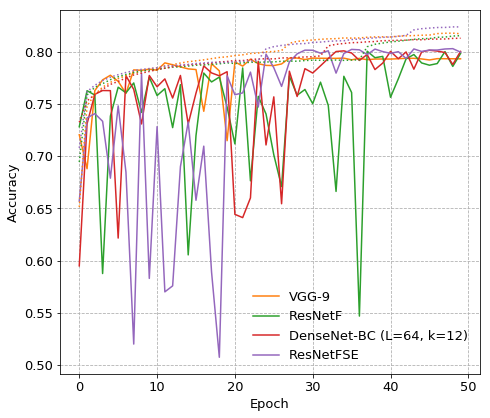

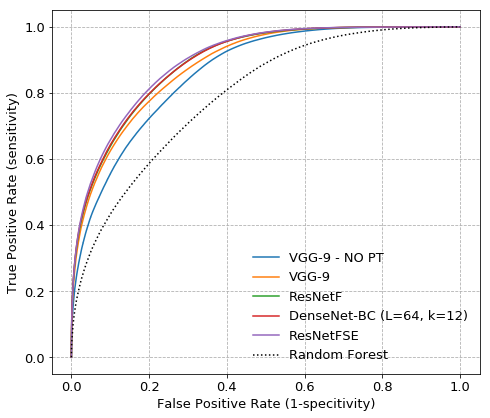

In [46]:
###############################################################################

############################## SEPARATION #####################################                

###############################################################################

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

baselineNOATh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/train-history'
baselineNOATr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/BaseLine_20_0.78306_0.77448.h5_test.csv'

baselineh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/train-history'
baseliner = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/BaseLine_29_0.80983_0.79393.h5_test.csv'

rnfh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/train-history'
rnfr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/ResNetF_38_0.80475_0.80049.h5_test.csv'

dnh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/train-history'
dnr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/DenseNet_46_0.81200_0.80139.h5_test.csv'

rnfseh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetFSE_2019-05-29_23-23/train-history'
rnfser = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetFSE_2019-05-29_23-23/ResNetFSE_49_0.82375_0.80292.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
baselineNOAT_history = pickle.load(open(baselineNOATh, 'rb'))
baseline_history = pickle.load(open(baselineh, 'rb'))
rnf_history = pickle.load(open(rnfh, 'rb'))
dn_history = pickle.load(open(dnh, 'rb'))
rnfse_history = pickle.load(open(rnfseh, 'rb'))

#compute ROCs
baselineNOAT_csv = pd.read_csv(baselineNOATr)
baseline_csv = pd.read_csv(baseliner)
rnf_csv = pd.read_csv(rnfr)
dn_csv = pd.read_csv(dnr)
rnfse_csv = pd.read_csv(rnfser)

rf_table = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_baselineNOAT, tpr_baselineNOAT, _ = roc_curve(baselineNOAT_csv['GroundTruth'], baselineNOAT_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rnf, tpr_rnf, _ = roc_curve(rnf_csv['GroundTruth'], rnf_csv['Predicted'])
fpr_dn, tpr_dn, _ = roc_curve(dn_csv['GroundTruth'], dn_csv['Predicted'])
fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])

epochs = 50

# training & test accuracy
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

#ax.plot(baselineNOAT_history['val_accuracy'], label='VGG-9 - NO PT', color=cmap(0))
plt.plot(baseline_history['val_accuracy'], label='VGG-9', color=cmap(1))
plt.plot(rnf_history['val_accuracy'], label='ResNetF', color=cmap(2))
plt.plot(dn_history['val_accuracy'], label='DenseNet-BC (L=64, k=12)', color=cmap(3))
plt.plot(rnfse_history['val_accuracy'], label='ResNetFSE', color=cmap(4))

#ax.plot(baselineNOAT_history['accuracy'], ':', color=cmap(0))
plt.plot(baseline_history['accuracy'], ':', color=cmap(1))
plt.plot(rnf_history['accuracy'], ':', color=cmap(2))
plt.plot(dn_history['accuracy'], ':', color=cmap(3))
plt.plot(rnfse_history['accuracy'], ':', color=cmap(4))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('class_history.eps', format='eps', bbox_inches='tight', transparent=False)

# training & test accuracy
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.plot(fpr_baselineNOAT, tpr_baselineNOAT, label='VGG-9 - NO PT', color=cmap(0))
plt.plot(fpr_baseline, tpr_baseline, label='VGG-9', color=cmap(1))
plt.plot(fpr_rnf, tpr_rnf, label='ResNetF', color=cmap(2))
plt.plot(fpr_dn, tpr_dn, label='DenseNet-BC (L=64, k=12)', color=cmap(3))
plt.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(4))
plt.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
plt.xlabel('False Positive Rate (1-specitivity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.legend(loc='lower right', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('class_res.eps', format='eps', bbox_inches='tight', transparent=False)

In [47]:
###############################################################################

####################### SEPARATION PROB DISTR BEST ############################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

rnfse_csv_g = rnfse_csv[rnfse_csv['GroundTruth'] == 1]
rnfse_csv_p = rnfse_csv[rnfse_csv['GroundTruth'] == 0]

g_count = rnfse_csv_g.shape[0]
p_count = rnfse_csv_p.shape[0]

print(g_count)
print(p_count)

fig = plt.figure(figsize=(7, 6))

plt.hist(rnfse_csv_g['Predicted'], bins=200, density = True, label='gammas', alpha = 0.8, edgecolor='gray', linewidth=0.9)
plt.hist(rnfse_csv_p['Predicted'], bins=200, density = True, label='protons', alpha = 0.8, edgecolor='gray', linewidth=0.9)
plt.yscale('log')
plt.ylim(top=100)
plt.xlabel('Gammaness', fontsize=13)
plt.ylabel('Frequency [%]', fontsize=13)
plt.legend(loc='upper right')
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

fig.tight_layout()
plt.show()
fig.savefig('separation_best_probdistr.pdf', format='pdf', bbox_inches='tight', transparent=False)

644890
645734


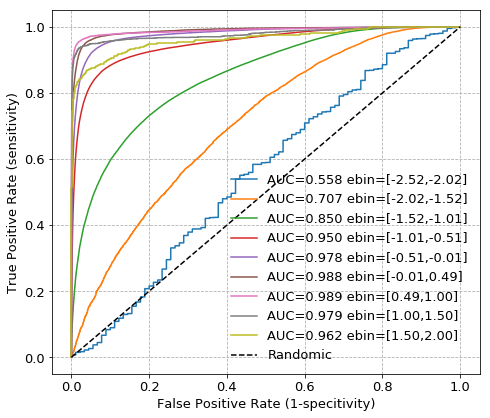

In [48]:
###############################################################################

############################# BEST MODEL ROCS #################################                

###############################################################################
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd
from scipy.stats import norm

best_sep = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/gammaness_energy.pkl'
df = pd.read_pickle(best_sep)

n_curves = 9
edges = np.linspace(min(df['mc_energy']), 2, n_curves + 1)

fig = plt.figure(figsize=(7, 6))
matplotlib.rcParams.update({'font.size': 13})

for i in range(n_curves):
    edge1 = edges[i]
    edge2 = edges[i+1]
    dfbe = df[(df['mc_energy'] >= edge1) & (df['mc_energy'] < edge2)]
    fpr, tpr, _ = roc_curve(dfbe['label'], dfbe['gammaness'])
    roc_auc = roc_auc_score(dfbe['label'], dfbe['gammaness'])
    # plt.plot(fpr, tpr, label='['+str(format(edge1,'.2f'))+','+str(format(edge2,'.2f'))+'] - '+'AUC='+str(format(roc_auc,'.2f')))
    plt.plot(fpr, tpr, label='AUC={:.3f} ebin=[{:.2f},{:.2f}]'.format(roc_auc, edge1, edge2))

plt.plot([0, 1], [0, 1], 'k--', label='Randomic')
plt.legend(loc='lower right', fancybox=True, framealpha=0.)
plt.xlabel('False Positive Rate (1-specitivity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

fig.tight_layout()
plt.show()
fig.savefig('rocs_best.eps', format='eps', bbox_inches='tight', transparent=False)

In [1]:
###############################################################################

######################################## ENERGY RECO ##########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib
import pickle

baselineNOATeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/train-history'
baselineNOATer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/BaseLine_47_0.22042_0.22049.h5_test.pkl'
baselineNOATems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/mus_sigmas.npz'

baselineeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/train-history'
baselineer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/BaseLine_30_0.15616_0.16365.h5_test.pkl'
baselineems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/mus_sigmas.npz'

resnetheh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/train-history'
resnether = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/ResNetH_27_0.11675_0.13286.h5_test.pkl'
resnethems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/mus_sigmas.npz'

resnethseeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/train-history'
resnethseer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/ResNetHSE_50_0.12730_0.13117.h5_test.pkl'
resnethseems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/mus_sigmas.npz'

densenet169eh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/train-history'
densenet169er = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/DenseNet169_43_0.13453_0.16394.h5_test.pkl'
densenet169ems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/mus_sigmas.npz'

denseneteh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/train-history'
denseneter = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/DenseNet_50_0.13568_0.13484.h5_test.pkl'
densenetems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/mus_sigmas.npz'

resnetfseeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/train-history'
resnetfseer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/ResNetFSE_44_0.12432_0.12943.h5_test.pkl'
resnetfseems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/mus_sigmas.npz'

#resnethseMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria\ delle\ Telecomunicazioni/2\ Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/train-history'
#resnethseMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/ResNetHSE_10_124.73765_102.66618.h5_test.pkl'
#resnethseMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/mus_sigmas.npz'

baselineNOATMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-19_00-06/train-history'
baselineNOATMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-19_00-06/BaseLine_48_67.23697_61.11096.h5_test.pkl'
baselineNOATMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-19_00-06/mus_sigmas.npz'

baselineMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-01_14-51/train-history'
baselineMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-01_14-51/BaseLine_49_57.57027_42.81926.h5_test.pkl'
baselineMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-01_14-51/mus_sigmas.npz'

resnethMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetH_energy_2019-06-19_03-41/train-history'
resnethMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetH_energy_2019-06-19_03-41/ResNetH_41_34.91076_45.36704.h5_test.pkl'
resnethMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetH_energy_2019-06-19_03-41/mus_sigmas.npz'

resnetfseMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetFSE_energy_2019-06-19_10-53/train-history'
resnetfseMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetFSE_energy_2019-06-19_10-53/ResNetFSE_34_48.59273_49.39331.h5_test.pkl'
resnetfseMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetFSE_energy_2019-06-19_10-53/mus_sigmas.npz'

densenetMAPEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/train-history'
densenetMAPEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/DenseNet_50_41.98650_41.43905.h5_test.pkl'
densenetMAPEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/mus_sigmas.npz'

baselineMSEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/train-history'
baselineMSEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/BaseLine_28_0.05555_0.10574.h5_test.pkl'
baselineMSEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/mus_sigmas.npz'

baselineNOATMSEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/train-history'
baselineNOATMSEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/BaseLine_28_0.11227_0.10560.h5_test.pkl'
baselineNOATMSEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/mus_sigmas.npz'

resnethMSEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/train-history'
resnethMSEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/ResNetH_36_0.03970_0.05129.h5_test.pkl'
resnethMSEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/mus_sigmas.npz'

densenetMSEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/train-history'
densenetMSEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/DenseNet_46_0.02955_0.03402.h5_test.pkl'
densenetMSEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/mus_sigmas.npz'

resnetfseMSEeh = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSE_energy_2019-06-19_09-31/train-history'
resnetfseMSEer = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSE_energy_2019-06-19_09-31/ResNetFSE_50_0.04624_0.06724.h5_test.pkl'
resnetfseMSEems = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSE_energy_2019-06-19_09-31/mus_sigmas.npz'

rftest = '/Volumes/WD500/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'

In [2]:
def get_mape(gt, p):
    return np.mean(np.abs((gt - p) / gt))

In [3]:
def get_mus_sigmas(pkl, npoints, rf=False):
    
    df = pd.read_pickle(pkl)
    
    energy = 'GroundTruth'
    energy_reco = 'Predicted'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        energy_reco = 'mc_energy_reco'

    # edges = np.linspace(min(df[energy_reco]), max(df[energy_reco]), npoints + 1)
    edges = np.linspace(-2, 2, npoints + 1)
    mus = np.array([])
    sigmas = np.array([])
    MAPEs = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy_reco] >= edge1) & (df[energy_reco] < edge2)]
        # histogram
        difE = ((dfbe[energy] - dfbe[energy_reco]) * np.log(10))
        # difE = difE[abs(difE) < 1.5]
        # mu, sigma = norm.fit(difE)
        mu, sigma = norm.fit(difE[abs(difE) < 1.5])
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        MAPEs = np.append(MAPEs, get_mape(dfbe[energy], dfbe[energy_reco]))
        
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, mus, sigmas, MAPEs

In [4]:
df_rf = pd.read_pickle(rftest)
df_baselineNOAT = pd.read_pickle(baselineNOATer)
df_baseline = pd.read_pickle(baselineer)
df_resneth = pd.read_pickle(resnether)
df_resnethse = pd.read_pickle(resnethseer)
df_densenet169 = pd.read_pickle(densenet169er)
df_densenet = pd.read_pickle(denseneter)
df_resnetfse = pd.read_pickle(resnetfseer)
df_baselineNOATMAPE = pd.read_pickle(baselineNOATMAPEer)
df_baselineMAPE = pd.read_pickle(baselineMAPEer)
df_resnethMAPE = pd.read_pickle(resnethMAPEer)
df_resnetfseMAPE = pd.read_pickle(resnetfseMAPEer)
df_densenetMAPE = pd.read_pickle(densenetMAPEer)
df_baselineMSE = pd.read_pickle(baselineMSEer)
df_baselineNOATMSE = pd.read_pickle(baselineNOATMSEer)
df_resnethMSE = pd.read_pickle(resnethMSEer)
df_densenetMSE = pd.read_pickle(densenetMSEer)
df_resnetfseMSE = pd.read_pickle(resnetfseMSEer)

MAPE_RF = get_mape(df_rf['mc_energy'], df_rf['mc_energy_reco'])

MAPE_resnethse = get_mape(df_resnethse['GroundTruth'], df_resnethse['Predicted'])
MAPE_densenet169 = get_mape(df_densenet169['GroundTruth'], df_densenet169['Predicted'])

MAPE_baselineNOAT = get_mape(df_baselineNOAT['GroundTruth'], df_baselineNOAT['Predicted'])
MAPE_baseline = get_mape(df_baseline['GroundTruth'], df_baseline['Predicted'])
MAPE_resneth = get_mape(df_resneth['GroundTruth'], df_resneth['Predicted'])
MAPE_densenet = get_mape(df_densenet['GroundTruth'], df_densenet['Predicted'])
MAPE_resnetfse = get_mape(df_resnetfse['GroundTruth'], df_resnetfse['Predicted'])

MAPE_baselineNOATMAPE = get_mape(df_baselineNOATMAPE['GroundTruth'], df_baselineNOATMAPE['Predicted'])
MAPE_baselineMAPE = get_mape(df_baselineMAPE['GroundTruth'], df_baselineMAPE['Predicted'])
MAPE_resnethMAPE = get_mape(df_resnethMAPE['GroundTruth'], df_resnethMAPE['Predicted'])
MAPE_resnetfseMAPE = get_mape(df_resnetfseMAPE['GroundTruth'], df_resnetfseMAPE['Predicted'])
MAPE_densenetMAPE = get_mape(df_densenetMAPE['GroundTruth'], df_densenetMAPE['Predicted'])

MAPE_baselineMSE = get_mape(df_baselineMSE['GroundTruth'], df_baselineMSE['Predicted'])
MAPE_baselineNOATMSE = get_mape(df_baselineNOATMSE['GroundTruth'], df_baselineNOATMSE['Predicted'])
MAPE_resnethMSE = get_mape(df_resnethMSE['GroundTruth'], df_resnethMSE['Predicted'])
MAPE_densenetMSE = get_mape(df_densenetMSE['GroundTruth'], df_densenetMSE['Predicted'])
MAPE_resnetfseMSE = get_mape(df_resnetfseMSE['GroundTruth'], df_resnetfseMSE['Predicted'])

print('MAPE RF', MAPE_RF)

print('----------------------------------------------')
print('MAPE resnethse', MAPE_resnethse)
print('MAPE densenet169', MAPE_densenet169)
print('----------------------------------------------')

print('MAPE baselineNOAT', MAPE_baselineNOAT)
print('MAPE baseline', MAPE_baseline)
print('MAPE resneth', MAPE_resneth)
print('MAPE densenet', MAPE_densenet)
print('MAPE resnetfse', MAPE_resnetfse)

print('----------------------------------------------')

print('MAPE baselineNOATMAPE', MAPE_baselineNOATMAPE)
print('MAPE baselineMAPE', MAPE_baselineMAPE)
print('MAPE resnethMAPE', MAPE_resnethMAPE)
print('MAPE resnetfseMAPE', MAPE_resnetfseMAPE)
print('MAPE densenetMAPE', MAPE_densenetMAPE)

print('----------------------------------------------')

print('MAPE baselineMSE', MAPE_baselineMSE)
print('MAPE baselineNOATMSE', MAPE_baselineNOATMSE)
print('MAPE resnethMSE', MAPE_resnethMSE)
print('MAPE densenetMSE', MAPE_densenetMSE)
print('MAPE resnetfseMSE', MAPE_resnetfseMSE)

MAPE RF 9.273192352297945
----------------------------------------------
MAPE resnethse 0.428711301798327
MAPE densenet169 0.5653561297280056
----------------------------------------------
MAPE baselineNOAT 1.3011632863502758
MAPE baseline 0.7539896643029571
MAPE resneth 0.4836645010888031
MAPE densenet 0.5745260150256942
MAPE resnetfse 0.47670763296637875
----------------------------------------------
MAPE baselineNOATMAPE 0.6417518369598457
MAPE baselineMAPE 0.39763774850075484
MAPE resnethMAPE 0.3873399337481362
MAPE resnetfseMAPE 0.5089800407104857
MAPE densenetMAPE 0.3559443368885525
----------------------------------------------
MAPE baselineMSE 1.547779040754866
MAPE baselineNOATMSE 1.1092022980261838
MAPE resnethMSE 0.8258711987777475
MAPE densenetMSE 0.47950506063148196
MAPE resnetfseMSE 0.5541803438956417


In [5]:
#history
baselineNOAT_history = pickle.load(open(baselineNOATeh, 'rb'))
baseline_history = pickle.load(open(baselineeh, 'rb'))
resneth_history = pickle.load(open(resnetheh, 'rb'))
resnethse_history = pickle.load(open(resnethseeh, 'rb'))
densenet169_history = pickle.load(open(densenet169eh, 'rb'))
densenet_history = pickle.load(open(denseneteh, 'rb'))
resnetfse_history = pickle.load(open(resnetfseeh, 'rb'))

'''
# mus & sigma
baselineNOAT_ms = np.load(baselineNOATems)
baseline_ms = np.load(baselineems)
resneth_ms = np.load(resnethems)
resnethse_ms = np.load(resnethseems)
densenet169_ms = np.load(densenet169ems)
densenet_ms = np.load(densenetems)
'''

# mus & sigma
npoints = 25
baselineNOAT_bc, baselineNOAT_m, baselineNOAT_s, baselineNOAT_mapes = get_mus_sigmas(baselineNOATer, npoints)
baseline_bc, baseline_m, baseline_s, baseline_mapes = get_mus_sigmas(baselineer, npoints)
resneth_bc, resneth_m, resneth_s, resneth_mapes = get_mus_sigmas(resnether, npoints)
resnethse_bc, resnethse_m, resnethse_s, resnethse_mapes = get_mus_sigmas(resnethseer, npoints)
densenet169_bc, densenet169_m, densenet169_s, densenet169_mapes = get_mus_sigmas(densenet169er, npoints)
densenet_bc, densenet_m, densenet_s, densenet_mapes = get_mus_sigmas(denseneter, npoints)
resnetfse_bc, resnetfse_m, resnetfse_s, resnetfse_mapes = get_mus_sigmas(resnetfseer, npoints)

baselineNOATMAPE_bc, baselineNOATMAPE_m, baselineNOATMAPE_s, baselineNOATMAPE_mapes = get_mus_sigmas(baselineNOATMAPEer, npoints)
baselineMAPE_bc, baselineMAPE_m, baselineMAPE_s, baselineMAPE_mapes = get_mus_sigmas(baselineMAPEer, npoints)
resnethMAPE_bc, resnethMAPE_m, resnethMAPE_s, resnethMAPE_mapes = get_mus_sigmas(resnethMAPEer, npoints)
resnetfseMAPE_bc, resnetfseMAPE_m, resnetfseMAPE_s, resnetfseMAPE_mapes = get_mus_sigmas(resnetfseMAPEer, npoints)
densenetMAPE_bc, densenetMAPE_m, densenetMAPE_s, densenetMAPE_mapes = get_mus_sigmas(densenetMAPEer, npoints)
baselineMSE_bc, baselineMSE_m, baselineMSE_s, baselineMSE_mapes = get_mus_sigmas(baselineMSEer, npoints)
baselineNOATMSE_bc, baselineNOATMSE_m, baselineNOATMSE_s, baselineNOATMSE_mapes = get_mus_sigmas(baselineNOATMSEer, npoints)
resnethMSE_bc, resnethMSE_m, resnethMSE_s, resnethMSE_mapes = get_mus_sigmas(resnethMSEer, npoints)
densenetMSE_bc, densenetMSE_m, densenetMSE_s, densenetMSE_mapes = get_mus_sigmas(densenetMSEer, npoints)
resnetfseMSE_bc, resnetfseMSE_m, resnetfseMSE_s, resnetfseMSE_mapes = get_mus_sigmas(resnetfseMSEer, npoints)

#rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
#rf_ms = np.load(rfms)

/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:190: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/cta-dev/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:195: RuntimeWarning: Mean of empty

In [6]:
#################### LOSS ONLY ####################################

rf_bc, rf_m, rf_s, rf_mapes = get_mus_sigmas(rftest, npoints, rf=True)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs
#ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO PT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(2))
ax.plot(resnetfse_history['val_losses'], label='ResNetFSE', color=cmap(3))
#ax.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(3))
#ax.plot(densenet169_history['val_losses'], label='DenseNet169', color=cmap(4))
ax.plot(densenet_history['val_losses'], label='DenseNet-BC (L=64, k=12)', color=cmap(5))


#ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.plot(resneth_history['losses'], ':', color=cmap(2))
ax.plot(resnetfse_history['losses'], ':', color=cmap(3))
#ax.plot(resnethse_history['losses'], ':', color=cmap(3))
#ax.plot(densenet169_history['losses'], ':', color=cmap(4))
ax.plot(densenet_history['losses'], ':', color=cmap(5))


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
#ax.set_yscale('log')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_history.eps', format='eps', bbox_inches='tight', transparent=False)

In [7]:
print(baselineNOAT_bc)

[1.22271989e-02 1.76736795e-02 2.55462393e-02 3.69255502e-02
 5.33736588e-02 7.71484092e-02 1.11513379e-01 1.61185873e-01
 2.32984471e-01 3.36765020e-01 4.86773554e-01 7.03601854e-01
 1.01701410e+00 1.47003263e+00 2.12484363e+00 3.07133349e+00
 4.43942758e+00 6.41692518e+00 9.27527886e+00 1.34068569e+01
 1.93788042e+01 2.80108943e+01 4.04880607e+01 5.85230532e+01
 8.45915485e+01]


In [8]:
#################### BIAS AND RESOLUTION ####################################

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.semilogx(baselineNOAT_bc, baselineNOAT_m, label='VGG-9 - NO PT,{:.2f}'.format(MAPE_baselineNOAT), color=cmap(0), marker='o')
plt.semilogx(baseline_bc, baseline_m, label='VGG-9,{:.2f}'.format(MAPE_baseline), color=cmap(1), marker='o')
plt.semilogx(resneth_bc, resneth_m, label='ResNetH,{:.2f}'.format(MAPE_resneth), color=cmap(2), marker='o')
plt.semilogx(resnetfse_bc, resnetfse_m, label='ResNetFSE,{:.2f}'.format(MAPE_resnetfse), color=cmap(3), marker='o')
#plt.semilogx(resnethse_bc, resnethse_m, label='ResNetHSE', color=cmap(3), marker='o')
#plt.semilogx(densenet169_bc, densenet169_m, label='DenseNet169', color=cmap(4), marker='o')
plt.semilogx(densenet_bc, densenet_m, label='DenseNet-BC (L=64, k=12),{:.2f}'.format(MAPE_densenet), color=cmap(5), marker='o')


#plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE', color=cmap(6), marker='o')
#plt.semilogx(baselineNOATMSE_bc, baselineNOATMSE_m, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
#plt.semilogx(baselineMSE_bc, baselineMSE_m, label='VGG9 - MSE', color=cmap(1), marker='1')
#plt.semilogx(resnethMSE_bc, resnethMSE_m, label='ResNetH - MSE', color=cmap(2), marker='1')
#plt.semilogx(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_m, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
#plt.semilogx(densenetMSE_bc, densenetMSE_m, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#plt.semilogx(CONST_bc, CONST_m, label='CONST', color=cmap(7), marker='D')


plt.semilogx(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)
plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias.eps', format='eps', bbox_inches='tight', transparent=False)
########################################################################################################
# reso & improvement
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
ax.semilogx(baselineNOAT_bc, baselineNOAT_s, label='VGG-9 - NO PT,{:.2f}'.format(MAPE_baselineNOAT), color=cmap(0), marker='o')
ax.semilogx(baseline_bc, baseline_s, label='VGG-9,{:.2f}'.format(MAPE_baseline), color=cmap(1), marker='o')
ax.semilogx(resneth_bc, resneth_s, label='ResNetH,{:.2f}'.format(MAPE_resneth), color=cmap(2), marker='o')
ax.semilogx(resnetfse_bc, resnetfse_s, label='ResNetFSE,{:.2f}'.format(MAPE_resnetfse), color=cmap(3), marker='o')
#ax.semilogx(resnethse_bc, resnethse_s, label='ResNetHSE', color=cmap(3), marker='o')
#ax.semilogx(densenet169_bc, densenet169_s, label='DenseNet-BC (L=64, k=12)', color=cmap(4), marker='o')
ax.semilogx(densenet_bc, densenet_s, label='DenseNet-BC (L=64, k=12),{:.2f}'.format(MAPE_densenet), color=cmap(5), marker='o')


#ax.semilogx(baselineMAPE_bc, baselineMAPE_s, label='VGG9 - MAPE', color=cmap(6), marker='o')
#ax.semilogx(baselineNOATMSE_bc, baselineNOATMSE_s, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
#ax.semilogx(baselineMSE_bc, baselineMSE_s, label='VGG9 - MSE', color=cmap(1), marker='1')
#ax.semilogx(resnethMSE_bc, resnethMSE_s, label='ResNetH - MSE', color=cmap(2), marker='1')
#ax.semilogx(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_s, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
#ax.semilogx(densenetMSE_bc, densenetMSE_s, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#ax.semilogx(CONST_bc, CONST_s, label='CONST', color=cmap(7), marker='D')

ax.semilogx(rf_bc, rf_s, color='black', label='Random Forest', linestyle=':', linewidth=2)
ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel(r'$(\Delta E/E)_{68}$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOAT_bc, (rf_s/baselineNOAT_s-1)*100, label='RF/VGG-9 - NO PT', color=cmap(0), marker='o')
ax.semilogx(baseline_bc, (rf_s/baseline_s-1)*100, label='RF/VGG-9', color=cmap(1), marker='o')
ax.semilogx(resneth_bc, (rf_s/resneth_s-1)*100, label='RF/ResNetH', color=cmap(2), marker='o')
ax.semilogx(resnetfse_bc, (rf_s/resnetfse_s-1)*100, label='ResNetFSE', color=cmap(3), marker='o')
#ax.semilogx(resnethse_bc, (rf_s/resnethse_s-1)*100, label='RF/ResNetHSE', color=cmap(3), marker='o')
#ax.semilogx(densenet169_bc, (rf_s/densenet169_s-1)*100, label='DenseNet-BC (L=64, k=12)', color=cmap(4), marker='o')
ax.semilogx(densenet_bc, (rf_s/densenet_s-1)*100, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#ax.semilogx(baselineMAPE_bc, rf_s/baselineMAPE_s, label='RF/VGG9 - MAPE', color=cmap(6), marker='o')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel('Enhancement %')
# ax.legend(loc='lower left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_reso.eps', format='eps', bbox_inches='tight', transparent=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'

In [ ]:
#################### BIAS AND RESOLUTION MSE ####################################

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.semilogx(baselineNOATMSE_bc, baselineNOATMSE_m, label='VGG9 - NOAT - MSE,{:.2f}'.format(MAPE_baselineNOATMSE), color=cmap(0), marker='o')
plt.semilogx(baselineMSE_bc, baselineMSE_m, label='VGG9 - MSE,{:.2f}'.format(MAPE_baselineMSE), color=cmap(1), marker='o')
plt.semilogx(resnethMSE_bc, resnethMSE_m, label='ResNetH - MSE,{:.2f}'.format(MAPE_resnethMSE), color=cmap(2), marker='o')
plt.semilogx(resnetfseMSE_bc, resnetfseMSE_m, label='ResNetFSE - MSE,{:.2f}'.format(MAPE_resnetfseMSE), color=cmap(3), marker='o')
plt.semilogx(densenetMSE_bc, densenetMSE_m, label='DenseNet-BC (L=64, k=12) - MSE,{:.2f}'.format(MAPE_densenetMSE), color=cmap(5), marker='o')

plt.semilogx(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)
plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias_mse.eps', format='eps', bbox_inches='tight', transparent=False)
########################################################################################################
# reso & improvement
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
ax.semilogx(baselineNOATMSE_bc, baselineNOATMSE_s, label='VGG-9 - NO PT - MSE,{:.2f}'.format(MAPE_baselineNOATMSE), color=cmap(0), marker='o')
ax.semilogx(baselineMSE_bc, baselineMSE_s, label='VGG-9 - MSE,{:.2f}'.format(MAPE_baselineMSE), color=cmap(1), marker='o')
ax.semilogx(resnethMSE_bc, resnethMSE_s, label='ResNetH - MSE,{:.2f}'.format(MAPE_resnethMSE), color=cmap(2), marker='o')
ax.semilogx(resnetfseMSE_bc, resnetfseMSE_s, label='ResNetFSE - MSE,{:.2f}'.format(MAPE_resnetfseMSE), color=cmap(3), marker='o')
ax.semilogx(densenetMSE_bc, densenetMSE_s, label='DenseNet-BC (L=64, k=12) - MSE,{:.2f}'.format(MAPE_densenetMSE), color=cmap(5), marker='o')

ax.semilogx(rf_bc, rf_s, color='black', label='Random Forest', linestyle=':', linewidth=2)
ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel(r'$(\Delta E/E)_{68}$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOATMSE_bc, (rf_s/baselineNOATMSE_s-1)*100, label='RF/VGG-9 - MSE - NO PT', color=cmap(0), marker='o')
ax.semilogx(baselineMSE_bc, (rf_s/baselineMSE_s-1)*100, label='RF/VGG-9 - MSE', color=cmap(1), marker='o')
ax.semilogx(resnethMSE_bc, (rf_s/resnethMSE_s-1)*100, label='RF/ResNetH - MSE', color=cmap(2), marker='o')
ax.semilogx(resnetfseMSE_bc, (rf_s/resnetfseMSE_s-1)*100, label='ResNetFSE - MSE', color=cmap(3), marker='o')
ax.semilogx(densenetMSE_bc, (rf_s/densenetMSE_s-1)*100, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='o')


#ax.semilogx(baselineMAPE_bc, rf_s/baselineMAPE_s, label='RF/VGG9 - MAPE', color=cmap(6), marker='o')

ax.hlines(1,baselineNOATMSE_bc.min(),baselineNOATMSE_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel('Enhancement %')
# ax.legend(loc='lower left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_reso_mse.eps', format='eps', bbox_inches='tight', transparent=False)

In [9]:
#################### BIAS AND RESOLUTION MAPE ####################################

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.semilogx(baselineNOATMAPE_bc, baselineNOATMAPE_m, label='VGG-9 - NOAT - MAPE,{:.2f}'.format(MAPE_baselineNOATMAPE), color=cmap(0), marker='o')
plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE,{:.2f}'.format(MAPE_baselineMAPE), color=cmap(1), marker='o')
plt.semilogx(resnethMAPE_bc[:-1], resnethMAPE_m[:-1], label='ResNetH - MAPE,{:.2f}'.format(MAPE_resnethMAPE), color=cmap(2), marker='o')
plt.semilogx(resnetfseMAPE_bc, resnetfseMAPE_m, label='ResNetFSE - MAPE,{:.2f}'.format(MAPE_resnetfseMAPE), color=cmap(3), marker='o')
plt.semilogx(densenetMAPE_bc, densenetMAPE_m, label='DenseNet-BC (L=64, k=12) - MAPE,{:.2f}'.format(MAPE_densenetMAPE), color=cmap(5), marker='o')

plt.semilogx(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)
plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias_MAPE.eps', format='eps', bbox_inches='tight', transparent=False)
########################################################################################################
# reso & improvement
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
ax.semilogx(baselineNOATMAPE_bc, baselineNOATMAPE_s, label='VGG-9 - NOAT - MAPE,{:.2f}'.format(MAPE_baselineNOATMAPE), color=cmap(0), marker='o')
ax.semilogx(baselineMAPE_bc, baselineMAPE_s, label='VGG9 - MAPE,{:.2f}'.format(MAPE_baselineMAPE), color=cmap(1), marker='o')
ax.semilogx(resnethMAPE_bc[:-1], resnethMAPE_s[:-1], label='ResNetH - MAPE,{:.2f}'.format(MAPE_resnethMAPE), color=cmap(2), marker='o')
ax.semilogx(resnetfseMAPE_bc, resnetfseMAPE_s, label='ResNetFSE - MAPE,{:.2f}'.format(MAPE_resnetfseMAPE), color=cmap(3), marker='o')
ax.semilogx(densenetMAPE_bc, densenetMAPE_s, label='DenseNet-BC (L=64, k=12) - MAPE,{:.2f}'.format(MAPE_densenetMAPE), color=cmap(5), marker='o')

ax.semilogx(rf_bc, rf_s, color='black', label='Random Forest', linestyle=':', linewidth=2)
ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel(r'$(\Delta E/E)_{68}$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOATMAPE_bc, (rf_s/baselineNOATMAPE_s-1)*100, label='RF/VGG-9 - NO PT - MAPE', color=cmap(0), marker='o')
ax.semilogx(baselineMAPE_bc, (rf_s/baselineMAPE_s-1)*100, label='RF/VGG-9 - MAPE', color=cmap(1), marker='o')
ax.semilogx(resnethMAPE_bc, (rf_s/resnethMAPE_s-1)*100, label='RF/ResNetH - MAPE', color=cmap(2), marker='o')
ax.semilogx(resnetfseMAPE_bc, (rf_s/resnetfseMAPE_s-1)*100, label='RF/ResNetFSE - MAPE', color=cmap(3), marker='o')
ax.semilogx(densenetMAPE_bc, (rf_s/densenetMAPE_s-1)*100, label='DenseNet-BC (L=64, k=12) - MAPE', color=cmap(5), marker='o')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{reco}}$[TeV]')
ax.set_ylabel('Enhancement %')
# ax.legend(loc='lower left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_reso_MAPE.eps', format='eps', bbox_inches='tight', transparent=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'

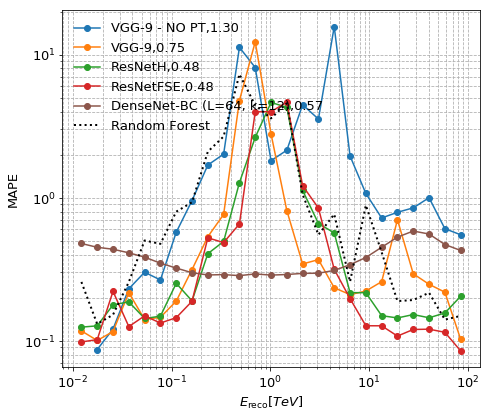

In [10]:

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.plot(baselineNOAT_bc, baselineNOAT_mapes, label='VGG-9 - NO PT,{:.2f}'.format(MAPE_baselineNOAT), color=cmap(0), marker='o')
plt.plot(baseline_bc, baseline_mapes, label='VGG-9,{:.2f}'.format(MAPE_baseline), color=cmap(1), marker='o')
plt.plot(resneth_bc, resneth_mapes, label='ResNetH,{:.2f}'.format(MAPE_resneth), color=cmap(2), marker='o')
plt.plot(resnetfse_bc, resnetfse_mapes, label='ResNetFSE,{:.2f}'.format(MAPE_resnetfse), color=cmap(3), marker='o')
plt.plot(densenet_bc, densenet_s, label='DenseNet-BC (L=64, k=12),{:.2f}'.format(MAPE_densenet), color=cmap(5), marker='o')

plt.plot(rf_bc, rf_mapes, color='black', label='Random Forest', linestyle=':', linewidth=2)

plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.xlabel('$E_{\mathrm{reco}}[TeV]$')
plt.ylabel('MAPE')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_mapes_mae.eps', format='eps', bbox_inches='tight', transparent=False)


# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.plot(baselineNOATMSE_bc, baselineNOATMSE_mapes, label='VGG-9 - MSE - NO PT,{:.2f}'.format(MAPE_baselineNOATMSE), color=cmap(0), marker='o')
plt.plot(baselineMSE_bc, baselineMSE_mapes, label='VGG-9 - MSE,{:.2f}'.format(MAPE_baselineMSE), color=cmap(1), marker='o')
plt.plot(resnethMSE_bc, resnethMSE_mapes, label='ResNetH - MSE,{:.2f}'.format(MAPE_resnethMSE), color=cmap(2), marker='o')
plt.plot(resnetfseMSE_bc, resnetfseMSE_mapes, label='ResNetFSE - MSE,{:.2f}'.format(MAPE_resnetfseMSE), color=cmap(3), marker='o')
plt.plot(densenetMSE_bc, densenetMSE_s, label='DenseNet-BC (L=64, k=12) - MSE,{:.2f}'.format(MAPE_densenetMSE), color=cmap(5), marker='o')

plt.plot(rf_bc, rf_mapes, color='black', label='Random Forest', linestyle=':', linewidth=2)

plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.xlabel('$E_{\mathrm{reco}}[TeV]$')
plt.ylabel('MAPE')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_mapes_mse.eps', format='eps', bbox_inches='tight', transparent=False)

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.plot(baselineNOATMAPE_bc, baselineNOATMAPE_mapes, label='VGG-9 - MAPE - NO PT,{:.2f}'.format(MAPE_baselineNOATMAPE), color=cmap(0), marker='o')
plt.plot(baselineMAPE_bc, baselineMAPE_mapes, label='VGG-9 - MAPE,{:.2f}'.format(MAPE_baselineMAPE), color=cmap(1), marker='o')
plt.plot(resnethMAPE_bc, resnethMAPE_mapes, label='ResNetH - MAPE,{:.2f}'.format(MAPE_resnethMAPE), color=cmap(2), marker='o')
plt.plot(resnetfseMAPE_bc, resnetfseMAPE_mapes, label='ResNetFSE - MAPE,{:.2f}'.format(MAPE_resnetfseMAPE), color=cmap(3), marker='o')
plt.plot(densenetMAPE_bc, densenetMAPE_s, label='DenseNet-BC (L=64, k=12) - MAPE,{:.2f}'.format(MAPE_densenetMAPE), color=cmap(5), marker='o')

plt.plot(rf_bc, rf_mapes, color='black', label='Random Forest', linestyle=':', linewidth=2)

plt.xscale('log', nonposx='clip')
plt.yscale('log', nonposy='clip')
plt.xlabel('$E_{\mathrm{reco}}[TeV]$')
plt.ylabel('MAPE')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_mapes_mape.eps', format='eps', bbox_inches='tight', transparent=False)

In [ ]:
"""
def get_mus_sigmas_const(df, npoints, rf=False):
    
    # df = pd.read_pickle(pkl)
    
    energy = 'GroundTruth'
    energy_reco = 'Predicted'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        energy_reco = 'mc_energy_reco'

    edges = np.linspace(min(df[energy]), 2, npoints + 1)
    mus = np.array([])
    sigmas = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy] >= edge1) & (df[energy] < edge2)]
        # histogram
        difE = ((dfbe[energy] - dfbe[energy_reco]) * np.log(10))
        # difE = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(difE)
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, mus, sigmas


df_CONST = df_resnetfseFIXEDMSE
df_CONST['Predicted'] = 0
CONST_bc, CONST_m, CONST_s = get_mus_sigmas_const(df_CONST, npoints)
"""

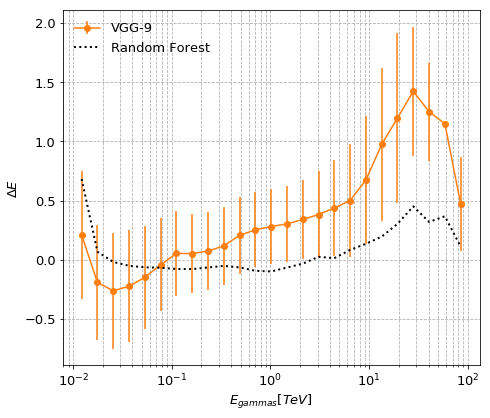

In [22]:

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

#plt.errorbar(baselineNOAT_bc, baselineNOAT_m, yerr=baselineNOAT_s, label='VGG-9 - NO PT', color=cmap(0), marker='o')
plt.errorbar(baseline_bc, baseline_m, yerr=baseline_s, label='VGG-9', color=cmap(1), marker='o')
#plt.errorbar(resneth_bc, resneth_m, yerr=resneth_s, label='ResNetH', color=cmap(2), marker='o')
#plt.errorbar(resnetfse_bc, resnetfse_m, yerr=resnetfse_s, label='ResNetFSE', color=cmap(3), marker='o')
#plt.semilogx(resnethse_bc, resnethse_m, label='ResNetHSE', color=cmap(3), marker='o')
#plt.semilogx(densenet169_bc, densenet169_m, label='DenseNet169', color=cmap(4), marker='o')
#plt.errorbar(densenet_bc, densenet_m, yerr=densenet_s, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE', color=cmap(6), marker='o')
#plt.errorbar(baselineNOATMSE_bc, baselineNOATMSE_m, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
#plt.errorbar(baselineMSE_bc, baselineMSE_m, label='VGG9 - MSE', color=cmap(1), marker='1')
#plt.errorbar(resnethMSE_bc, resnethMSE_m, label='ResNetH - MSE', color=cmap(2), marker='1')
#plt.errorbar(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_m, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
#plt.errorbar(densenetMSE_bc, densenetMSE_m, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#plt.semilogx(CONST_bc, CONST_m, label='CONST', color=cmap(7), marker='D')

plt.errorbar(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)

plt.xscale('log', nonposx='clip')

plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_errorbars.eps', format='eps', bbox_inches='tight', transparent=False)

In [11]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAMS ###########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['Predicted']), max(df['Predicted']), n_figs + 1)
mus = np.array([])
sigmas = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['GroundTruth'] >= edge1) & (df['GroundTruth'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = ((dfbe['GroundTruth'] - dfbe['Predicted']) * np.log(10))
        #section = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(difE[abs(difE) < 1.5])
        print('MU: ', mu, 'SIGMA: ', sigma, 'N EVENTS:', dfbe.shape[0])
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        n, bins, patches = plt.hist(difE, 100, density=True, alpha=1)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--', linewidth=2)
        plt.xlabel('$(log_{10}(E_{\mathrm{gammas}}\mathrm{[TeV]})-log_{10}(E_{\mathrm{rec}}\mathrm{[TeV]}))*log(10)$', fontsize=15)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        #plt.title('Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{\mathrm{gammas}}\mathrm{[TeV]})$',
        #         fontsize=15)
        plt.title(str(round(10 ** edge1, 3)) + '$\mathrm{TeV} < E_{\mathrm{rec}} <$' + str(round(10 ** edge2, 3)) + 'TeV', fontsize=15)
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')

#fig.tight_layout(rect=[0, 0.03, 1, 0.85])
fig.tight_layout()
plt.show()
fig.savefig('energy_best_histogram.eps', format='eps', bbox_inches='tight', transparent=False)

MU:  -0.5822049915851899 SIGMA:  0.27209432950122264 N EVENTS: 77427
MU:  -0.20302164658436647 SIGMA:  0.2911135310107428 N EVENTS: 152983
MU:  0.0341965968873242 SIGMA:  0.3064430443797917 N EVENTS: 145198
MU:  0.11647735429765714 SIGMA:  0.3035953674776282 N EVENTS: 108699
MU:  0.1444788432591712 SIGMA:  0.2681655418107681 N EVENTS: 72628
MU:  0.26531700601815866 SIGMA:  0.2650694476405336 N EVENTS: 40324
MU:  0.36065664188772684 SIGMA:  0.3022363997670467 N EVENTS: 20524
MU:  0.4099708476013491 SIGMA:  0.3148388118791567 N EVENTS: 9088
MU:  0.4614061111591975 SIGMA:  0.33524581364543116 N EVENTS: 4205
MU:  0.6289196199147274 SIGMA:  0.3436455559822745 N EVENTS: 1896
MU:  0.8802595918241068 SIGMA:  0.31727439826372655 N EVENTS: 807
MU:  1.158759881046251 SIGMA:  0.24778265143146966 N EVENTS: 374


In [12]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAM 2D #########################                

###############################################################################

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

fig = plt.figure(figsize=(10, 8))

hE = plt.hist2d(df['GroundTruth'], df['Predicted'], bins=100, norm=LogNorm())
plt.colorbar(hE[3])
plt.xlabel('$log_{10}E_{\mathrm{gammas}}$[TeV]', fontsize=13)
plt.ylabel('$log_{10}E_{\mathrm{rec}}$[TeV]', fontsize=13)
plt.plot(df['GroundTruth'], df['GroundTruth'], "-", color='red')

#plt.title('Histogram2D - Energy reconstruction')
fig.tight_layout()
plt.show()
fig.savefig('energy_best_hist2d.pdf', format='pdf', bbox_inches='tight', transparent=True)

In [37]:
def get_theta2_68(pkl, npoints, rf=False):
    
    df = pd.read_pickle(pkl)
    
    energy = 'energy'
    alt = 'src_x'
    az = 'src_y'
    alt_reco = 'src_x_rec'
    az_reco = 'src_y_rec'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        alt = 'd_alt'
        az = 'd_az'
        alt_reco = 'd_alt_reco'
        az_reco = 'd_az_reco'
        
    
    edges = np.linspace(min(df[energy]), 2, npoints + 1)
    theta2_68 = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy] >= edge1) & (df[energy] < edge2)]
        theta2 = (dfbe[alt] - dfbe[alt_reco]) ** 2 + (dfbe[az] - dfbe[az_reco]) ** 2
        # 68% containement computation
        total = len(theta2)
        hist = np.histogram(theta2, bins=1000)
        for k in range(0, len(hist[0]) + 1):
            fraction = np.sum(hist[0][:k]) / total
            if fraction > 0.68:
                #if rf:
                #    print('\nTotal: ', total)
                #    print('0.68 of total:', np.sum(hist[0][:k]))
                #    print('Fraction:', fraction)
                theta2_68 = np.append(theta2_68, hist[1][k])
                break
                
    # back to linear
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, theta2_68

[166.65718293 140.71017803  87.15642505  41.96799652  22.2733067
  20.51750757  27.90902774  38.9206265   41.47579378  87.27246446]
[182.2741438  151.65930811 102.71411707  51.17496235  27.98418558
  29.07383687  38.64940309  47.09431695  46.99837612  96.66544244]


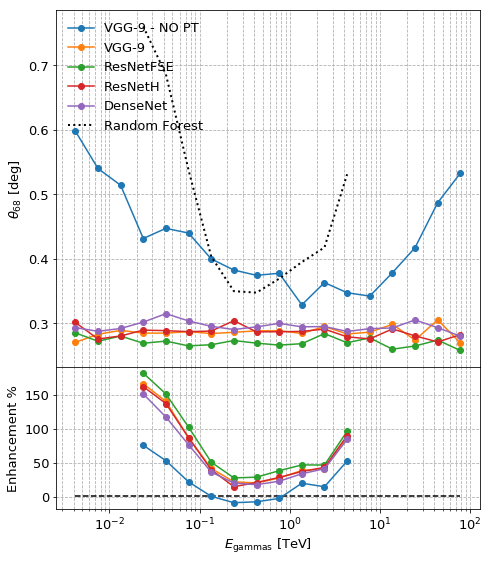

In [38]:
###############################################################################

######################################### DIRE RECO ###########################                

###############################################################################

# direction reconstruction
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import numpy as np

baselineNOATdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/train-history'
baselineNOATdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/ang_reso_plt.npz'
baselineNOATdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/BaseLine_49_0.50128_0.45132.h5_test.pkl'

baselineONLYATdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/ANGULAR_ONLYAT/BaseLine_xy_2019-06-21_08-54/train-history'
baselineONLYATdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/ANGULAR_ONLYAT/BaseLine_xy_2019-06-21_08-54/ang_reso_plt.npz'
baselineONLYATdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/ANGULAR_ONLYAT/BaseLine_xy_2019-06-21_08-54/BaseLine_47_0.44405_0.47740.h5_test.pkl'

baselinedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/train-history'
baselinedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/ang_reso_plt.npz'
baselinedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/BaseLine_25_0.34697_0.32997.h5_test.pkl'

resnetfsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/train-history'
resnetfsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ang_reso_plt.npz'
resnetfsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ResNetFSE_48_0.21978_0.22281.h5_test.pkl'

resnetfseFIXEDdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/train-history'
resnetfseFIXEDdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/ang_reso_plt.npz'
resnetfseFIXEDdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/ResNetFSEFixed_50_0.21650_0.22598.h5_test.pkl'

resnetfdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/train-history'
resnetfdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/ang_reso_plt.npz'
resnetfdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/ResNetF_40_0.20012_0.23381.h5_test.pkl'

resnethdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/train-history'
resnethdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ang_reso_plt.npz'
resnethdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ResNetH_34_0.18375_0.21594.h5_test.pkl'

resnethsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/train-history'
resnethsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ang_reso_plt.npz'
resnethsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ResNetHSE_49_0.21935_0.22435.h5_test.pkl'

baselineNOATMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/train-history'
baselineNOATMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/ang_reso_plt.npz'
baselineNOATMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/BaseLine_35_0.80899_0.87613.h5_test.pkl'

baselineMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/train-history'
baselineMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/ang_reso_plt.npz'
baselineMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/BaseLine_18_0.30677_0.33684.h5_test.pkl'

resnetfseMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/train-history'
resnetfseMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/ang_reso_plt.npz'
resnetfseMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/ResNetFSE_47_0.12410_0.17007.h5_test.pkl'

densenetdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/train-history'
densenetdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/ang_reso_plt.npz'
densenetdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/DenseNet_49_0.24333_0.24288.h5_test.pkl'

#history
baselineNOAT_history = pickle.load(open(baselineNOATdh, 'rb'))
baseline_history = pickle.load(open(baselinedh, 'rb'))
resnetfse_history = pickle.load(open(resnetfsedh, 'rb'))
resnetfseFIXED_history = pickle.load(open(resnetfsedh, 'rb'))
resneth_history = pickle.load(open(resnethdh, 'rb'))
resnethse_history = pickle.load(open(resnethsedh, 'rb'))
densenet_history = pickle.load(open(densenetdh, 'rb'))
resnetf_history = pickle.load(open(resnetfdh, 'rb'))

baselineNOATMSE_history = pickle.load(open(baselineNOATMSEdh, 'rb'))
baselineMSE_history = pickle.load(open(baselineMSEdh, 'rb'))
resnetfseMSE_history = pickle.load(open(resnetfseMSEdh, 'rb'))

# angulare reso
npoints = 18
baselineNOAT_bc, baselineNOAT_areso = get_theta2_68(baselineNOATdtest, npoints)
baselineONLYAT_bc, baselineONLYAT_areso = get_theta2_68(baselineONLYATdtest, npoints)
baseline_bc, baseline_areso = get_theta2_68(baselinedtest, npoints)
resnetfse_bc, resnetfse_areso = get_theta2_68(resnetfsedtest, npoints)
resnetfseFIXED_bc, resnetfseFIXED_areso = get_theta2_68(resnetfseFIXEDdtest, npoints)
resneth_bc, resneth_areso = get_theta2_68(resnethdtest, npoints)
resnethse_bc, resnethse_areso = get_theta2_68(resnethsedtest, npoints)
densenet_bc, densenet_areso = get_theta2_68(densenetdtest, npoints)
resnetf_bc, resnetf_areso = get_theta2_68(resnetfdtest, npoints)

baselineNOATMSE_bc, baselineNOATMSE_areso = get_theta2_68(baselineNOATMSEdtest, npoints)
baselineMSE_bc, baselineMSE_areso = get_theta2_68(baselineMSEdtest, npoints)
resnetfseMSE_bc, resnetfseMSE_areso = get_theta2_68(resnetfseMSEdtest, npoints)

rftest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'
rf_bc, rf_areso = get_theta2_68(rftest, npoints, rf=True)

############# LOAD POINTS RF #############################

nocutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/nocut.csv')
softcutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/softcut.csv')
hardcutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/hardcut.csv')
    
# need to interpolate rf points, in order to compare them with the other models

f_rf_a = interpolate.interp1d(nocutcsv['x'], nocutcsv['no_cut'], kind='linear')

#take only points inside hand copied curve
which_idxs = np.where((baselineNOAT_bc >=nocutcsv['x'].min()) & (baselineNOAT_bc <=nocutcsv['x'].max()))  
x_nocut_new = baselineNOAT_bc[which_idxs]
y_nocut_new = f_rf_a(x_nocut_new)
    
    
epochs = 50

# training & test loss
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

#plt.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO PT', color=cmap(0))
plt.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
plt.plot(resnetfse_history['val_losses'], label='ResNetFSE', color=cmap(2))
plt.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(3))
plt.plot(densenet_history['val_losses'], label='DenseNet', color=cmap(4))
#plt.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(5))
#plt.plot(resnetf_history['val_losses'], label='ResNetF', color=cmap(6))

#plt.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
plt.plot(baseline_history['losses'], ':', color=cmap(1))
plt.plot(resnetfse_history['losses'], ':', color=cmap(2))
plt.plot(resneth_history['losses'], ':', color=cmap(3))
plt.plot(densenet_history['losses'], ':', color=cmap(4))
#ax.plot(resnethse_history['losses'], ':', color=cmap(5))
plt.plot(resnetf_history['losses'], ':', color=cmap(6))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('dirreco_losshistory.eps', format='eps', bbox_inches='tight', transparent=False)
#############################################################################

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
#ax.set_yscale('log')
ax.semilogx(baselineNOAT_bc, np.sqrt(baselineNOAT_areso), label='VGG-9 - NO PT', color=cmap(0), marker='o')
ax.semilogx(baseline_bc, np.sqrt(baseline_areso), label='VGG-9', color=cmap(1), marker='o')
ax.semilogx(resnetfse_bc, np.sqrt(resnetfse_areso), label='ResNetFSE', color=cmap(2), marker='o')
#ax.semilogx(resnetfseFIXED_bc, np.sqrt(resnetfseFIXED_areso), label='ResNetFSEFIXED', color=cmap(2), marker='1')
ax.semilogx(resneth_bc, np.sqrt(resneth_areso), label='ResNetH', color=cmap(3), marker='o')
ax.semilogx(densenet_bc, np.sqrt(densenet_areso), label='DenseNet', color=cmap(4), marker='o')
#ax.semilogx(resnethse_bc, np.sqrt(resnethse_areso), label='ResNetHSE', color=cmap(5), marker='o')
#ax.semilogx(resnetf_bc, np.sqrt(resnetf_areso), label='ResNetF', color=cmap(6), marker='o')
#ax.semilogx(baselineONLYAT_bc, np.sqrt(baselineONLYAT_areso), label='baselineONLYAT', color=cmap(6), marker='o')

#ax.semilogx(baselineNOATMSE_bc, np.sqrt(baselineNOATMSE_areso), label='VGG-9 - NO PT - MSE', color=cmap(0), marker='1')
#ax.semilogx(baselineMSE_bc, np.sqrt(baselineMSE_areso), label='VGG-9 - MSE', color=cmap(1), marker='1')
#ax.semilogx(resnetfseMSE_bc, np.sqrt(resnetfseMSE_areso), label='ResNetFSE - MSE', color=cmap(2), marker='1')

#ax.semilogx(rf_bc, np.sqrt(rf_areso), label='Random Forest', color='black', marker='o') # linestyle='o'
ax.semilogx(x_nocut_new, y_nocut_new, label='Random Forest', linestyle=':', color='black', linewidth=2)
#ax.semilogx(softcutcsv['x'], softcutcsv['soft_cut'], label='Random Forest - soft cut', color='black', marker='v')
#ax.semilogx(hardcutcsv['x'], hardcutcsv['hard_cut'], label='Random Forest - hard cut', color='black', marker='h')

ax.set_xlabel('$E_{\mathrm{gammas}}$ [TeV]')
ax.set_ylabel(r'$\theta_{68}$ [deg]')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(x_nocut_new, (y_nocut_new/np.sqrt(baselineNOAT_areso[which_idxs])-1)*100, label='RF/VGG-9 - NO PT', color=cmap(0), marker='o')
ax.semilogx(x_nocut_new, (y_nocut_new/np.sqrt(baseline_areso[which_idxs])-1)*100, label='RF/VGG-9', color=cmap(1), marker='o')
ax.semilogx(x_nocut_new, (y_nocut_new/np.sqrt(resnetfse_areso[which_idxs])-1)*100, label='RF/ResNetFSE', color=cmap(2), marker='o')
ax.semilogx(x_nocut_new, (y_nocut_new/np.sqrt(resneth_areso[which_idxs])-1)*100, label='RF/ResNetH', color=cmap(3), marker='o')
ax.semilogx(x_nocut_new, (y_nocut_new/np.sqrt(densenet_areso[which_idxs])-1)*100, label='RF/DenseNet', color=cmap(4), marker='o')
#ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(resnethse_areso[which_idxs]), label='RF/ResNetHSE', color=cmap(5), marker='o')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{gammas}}$ [TeV]')
ax.set_ylabel('Enhancement %')
#ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('dirreco_results.eps', format='eps', bbox_inches='tight', transparent=False)

print((y_nocut_new/np.sqrt(baseline_areso[which_idxs])-1)*100)
print((y_nocut_new/np.sqrt(resnetfse_areso[which_idxs])-1)*100)

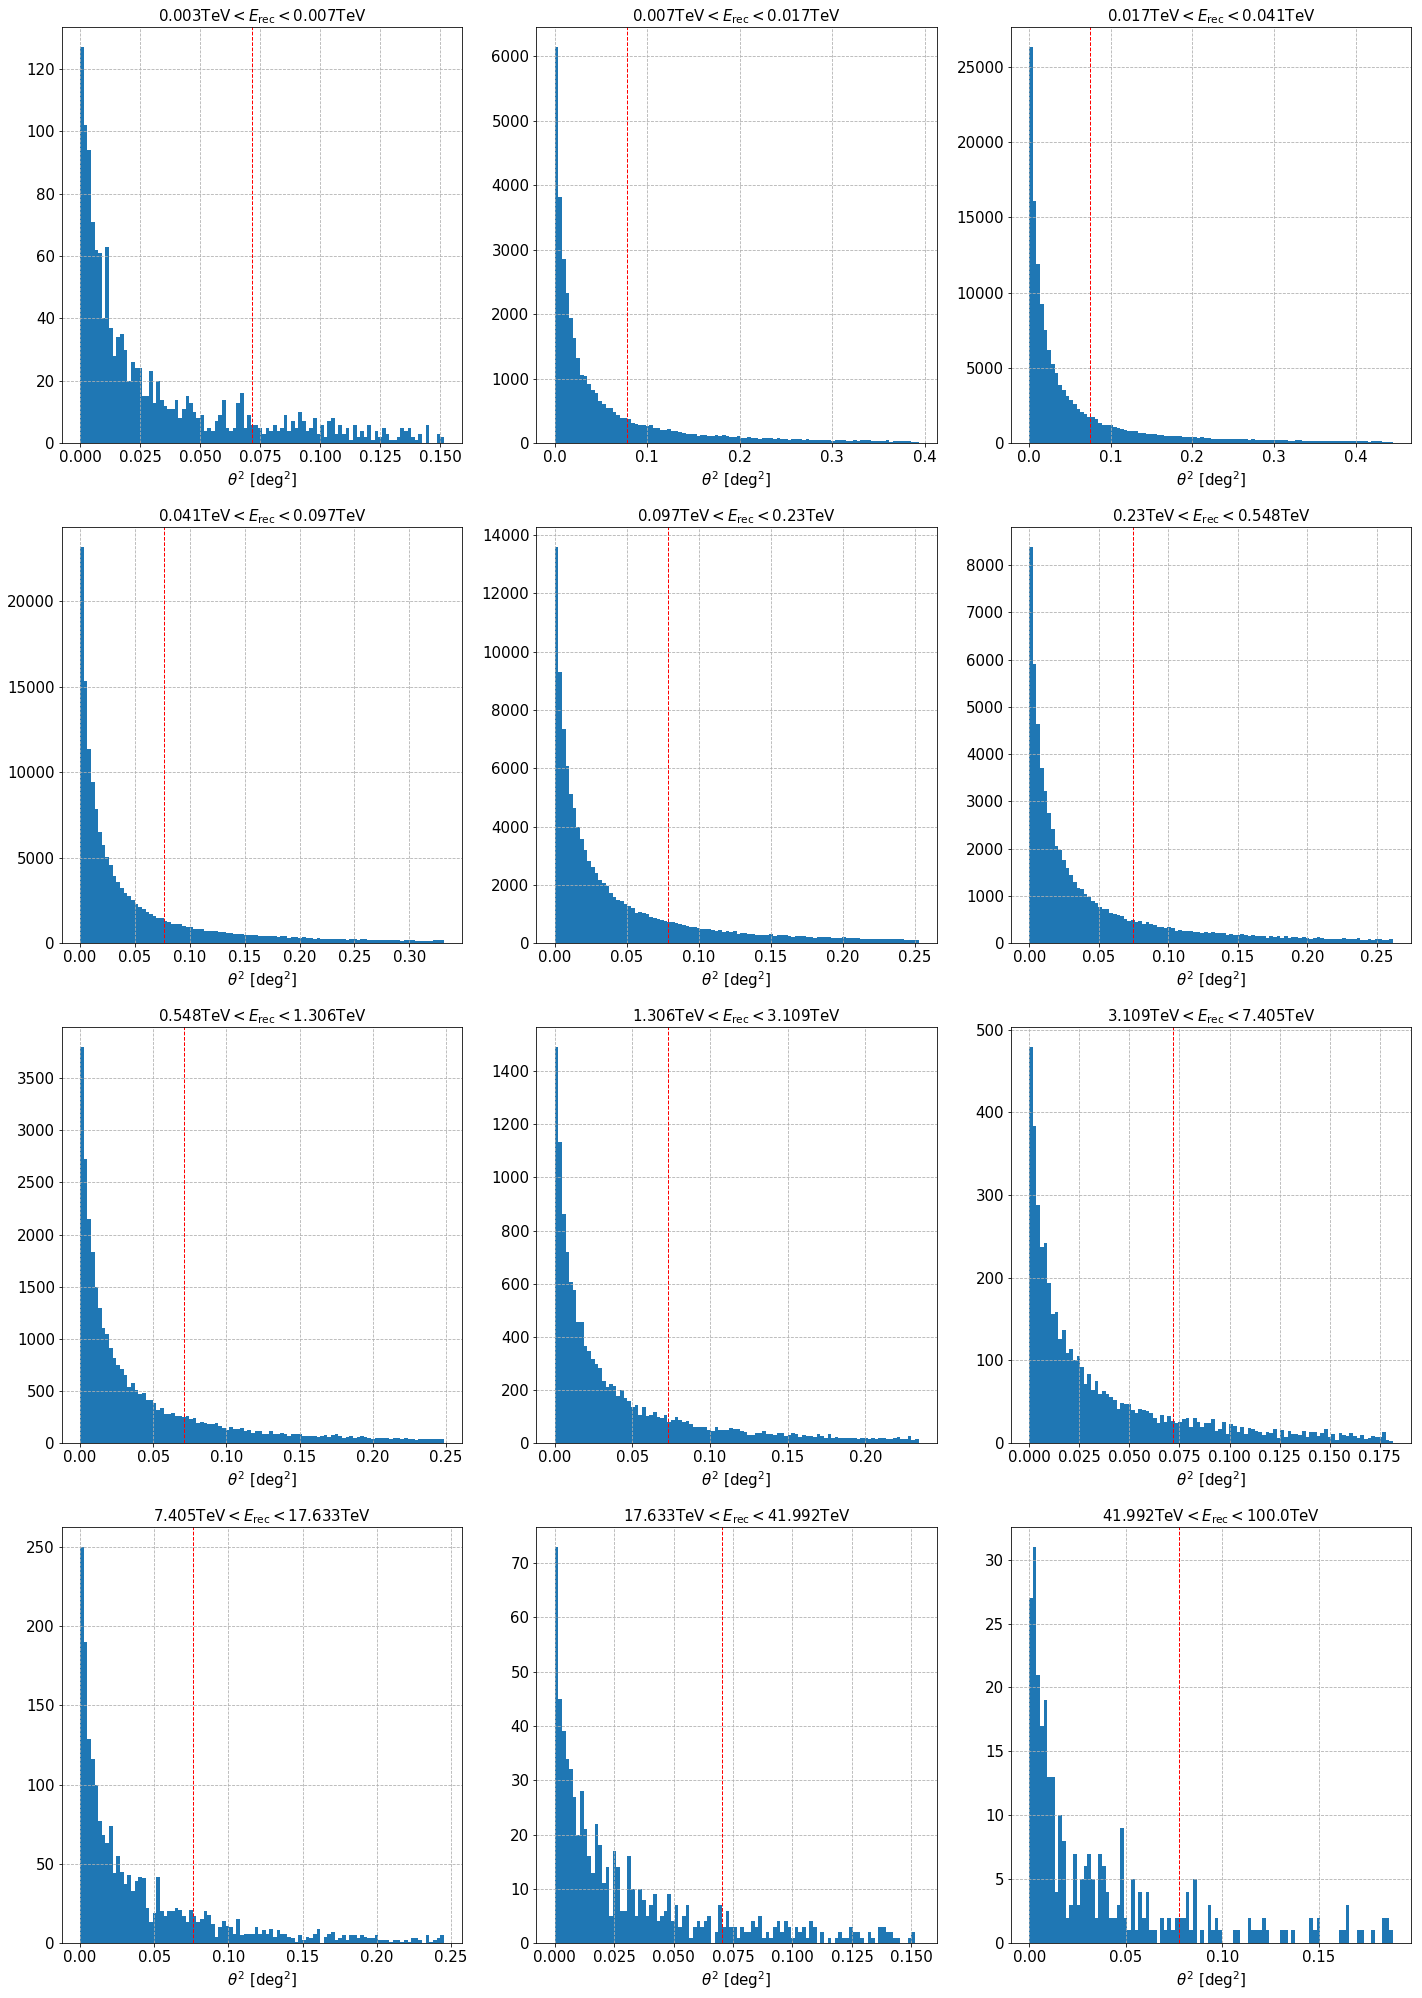

In [39]:
###############################################################################

###################### BEST MODEL DIRECTION HISTOGRAMS ########################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(resnetfsedtest)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['energy']), 2, n_figs + 1)
theta2_68 = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        dfbe = df[(df['energy'] >= edge1) & (df['energy'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        theta2 = (dfbe['src_x'] - dfbe['src_x_rec']) ** 2 + (dfbe['src_y'] - dfbe['src_y_rec']) ** 2
        total = len(theta2)
        # theta2_68 = np.append(theta2_68, np.percentile(theta2, 68))
        hist = np.histogram(theta2, bins=1000)
        for k in range(0, len(hist[0]) + 1):
            fraction = np.sum(hist[0][:k]) / total
            if fraction > 0.68:
                #print('\nTotal: ', total)
                #print('0.68 of total:', np.sum(hist[0][:k]))
                #print('Fraction:', fraction)
                theta2_68 = np.append(theta2_68, hist[1][k])
                break
        # n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k+1])) #hist[1][k+1] one bin more than 68% cont
        n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k+20]))
        plt.axvline(hist[1][k], color='r', linestyle='dashed', linewidth=1)
        #plt.yscale('log', nonposy='clip')
        plt.xlabel(r'$\theta^{2}$ [deg$^2$]', fontsize=15)
        #plt.title(
        #    'Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{\mathrm{gammas}})$[TeV]')
        plt.title(str(round(10 ** edge1, 3)) + '$\mathrm{TeV} < E_{\mathrm{rec}} <$' + str(round(10 ** edge2, 3)) + 'TeV', fontsize=15)
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')
        # + ' Mean: ' + str(round(mu, 3)) + ' Std: ' + str(round(sigma, 3)))

fig.tight_layout()
plt.show()
fig.savefig('best_direco_histograms.eps', format='eps', bbox_inches='tight', transparent=False)

In [8]:
import tables
import numpy as np
file_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun819-4897___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_gamma = tables.open_file(file_gamma)

file_proton = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_proton = tables.open_file(file_proton)

In [9]:
def get_event_data(data):

    data_einfo = data.root.Event_Info
    ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
    
    return ei_mc_energy

In [10]:
def get_LST_data(data):

    data_LST = data.root.LST

    # LST data
    LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
    LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
    LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

    return data_LST, LST_event_index, LST_image_charge, LST_image_peak_times

In [11]:
_, LST_event_index_proton, LST_image_charge_proton, LST_image_peak_times_proton = get_LST_data(data_proton)
_, LST_event_index_gamma, LST_image_charge_gamma, LST_image_peak_times_gamma = get_LST_data(data_gamma)

In [12]:
ei_mc_energy_gamma = get_event_data(data_gamma)
print(np.min(ei_mc_energy_gamma)) # TeV
print(np.max(ei_mc_energy_gamma)) # TeV

np.argmax(ei_mc_energy_gamma)

0.003943628631532192
199.24337768554688


295

In [13]:
ei_mc_energy_proton = get_event_data(data_proton)
print(np.min(ei_mc_energy_proton)) # TeV
print(np.max(ei_mc_energy_proton)) # TeV

np.argmax(ei_mc_energy_proton)

0.010546076111495495
567.3707275390625


999

In [14]:
# print event information
img_charge_proton = LST_image_charge_proton[999]
img_time_proton = LST_image_peak_times_proton[999]

img_charge_gamma = LST_image_charge_gamma[4309]
img_time_gamma = LST_image_peak_times_gamma[4309]

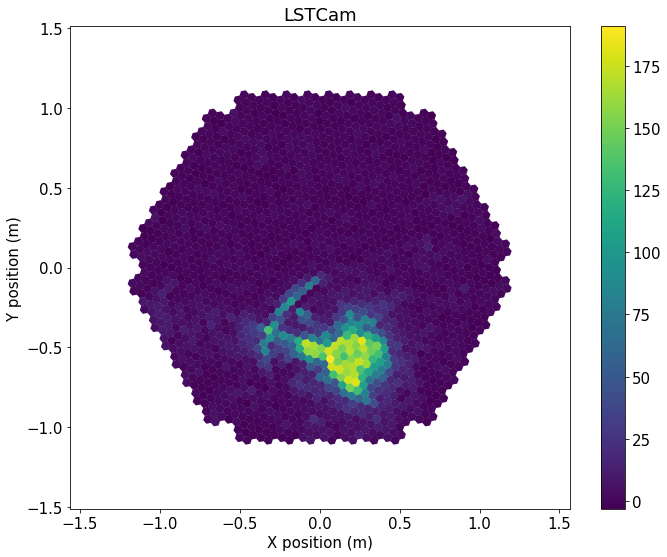

In [17]:
import matplotlib
import matplotlib.pyplot as plt
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'axes.labelsize': 15})

camera = CameraGeometry.from_name('LSTCam')
fig = plt.figure(figsize=(10, 8))
display = CameraDisplay(camera)
display.image = img_charge_proton
display.add_colorbar()

fig.tight_layout()
fig.savefig('proton.eps', format='eps', bbox_inches='tight', transparent=False)

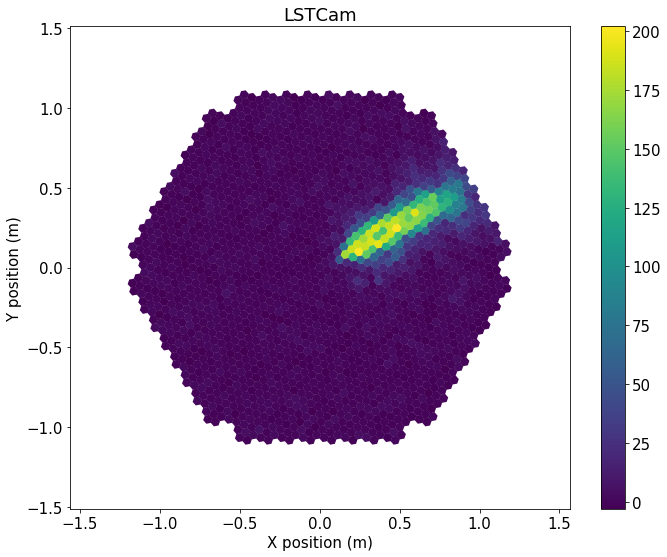

In [18]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'axes.labelsize': 15})

camera = CameraGeometry.from_name('LSTCam')
fig = plt.figure(figsize=(10, 8))
display = CameraDisplay(camera)
display.image = img_charge_gamma
display.add_colorbar()

fig.tight_layout()
fig.savefig('gamma.eps', format='eps', bbox_inches='tight', transparent=False)

{'intensity': 14254.16766500473,
 'kurtosis': 1.9822153974061614,
 'length': <Quantity 0.24395298 m>,
 'phi': <Angle 0.48819392 rad>,
 'psi': <Angle 0.49867318 rad>,
 'r': <Quantity 0.59814519 m>,
 'skewness': 0.10884334423155458,
 'width': <Quantity 0.10303297 m>,
 'x': <Quantity 0.52827071 m>,
 'y': <Quantity 0.28054897 m>}


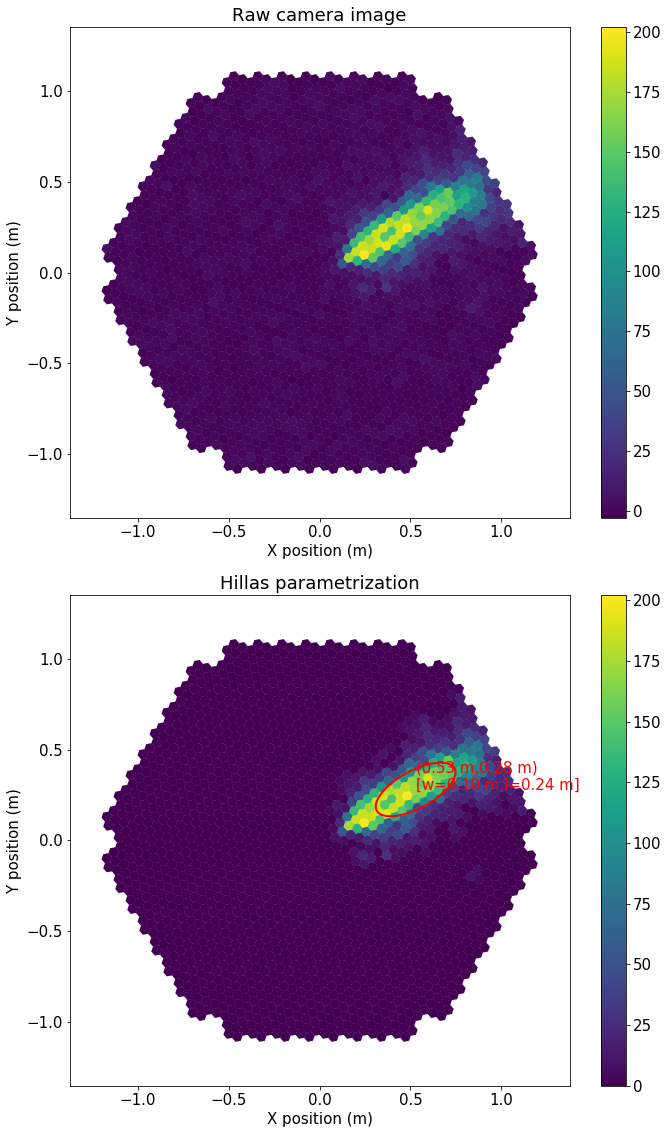

In [19]:
# hillas parameters
import matplotlib
from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'axes.labelsize': 15})

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera image")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
# cleanmask = tailcuts_clean(
#    geom, img_charge, picture_thresh=10, boundary_thresh=5
#)

# Calculate image parameters
#hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge_gamma
#disp.highlight_pixels(cleanmask, color='crimson')
#disp.overlay_moments(hillas, color='cyan', linewidth=3)

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

ax = plt.subplot(2, 1, 2)

disp = CameraDisplay(geom, ax=ax, title="Hillas parametrization")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge_gamma, picture_thresh=10, boundary_thresh=5
)

# Calculate image parameters
hillas = hillas_parameters(geom[cleanmask], img_charge_gamma[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
cleaned = img_charge_gamma.copy()
cleaned[~cleanmask] = 0.0
disp.image = cleaned
#disp.highlight_pixels(cleanmask, color='crimson')
disp.overlay_moments(hillas, color='red', linewidth=2)

print(hillas)

fig.tight_layout()
fig.savefig('raw_hillas.eps', format='eps', bbox_inches='tight')
plt.show()

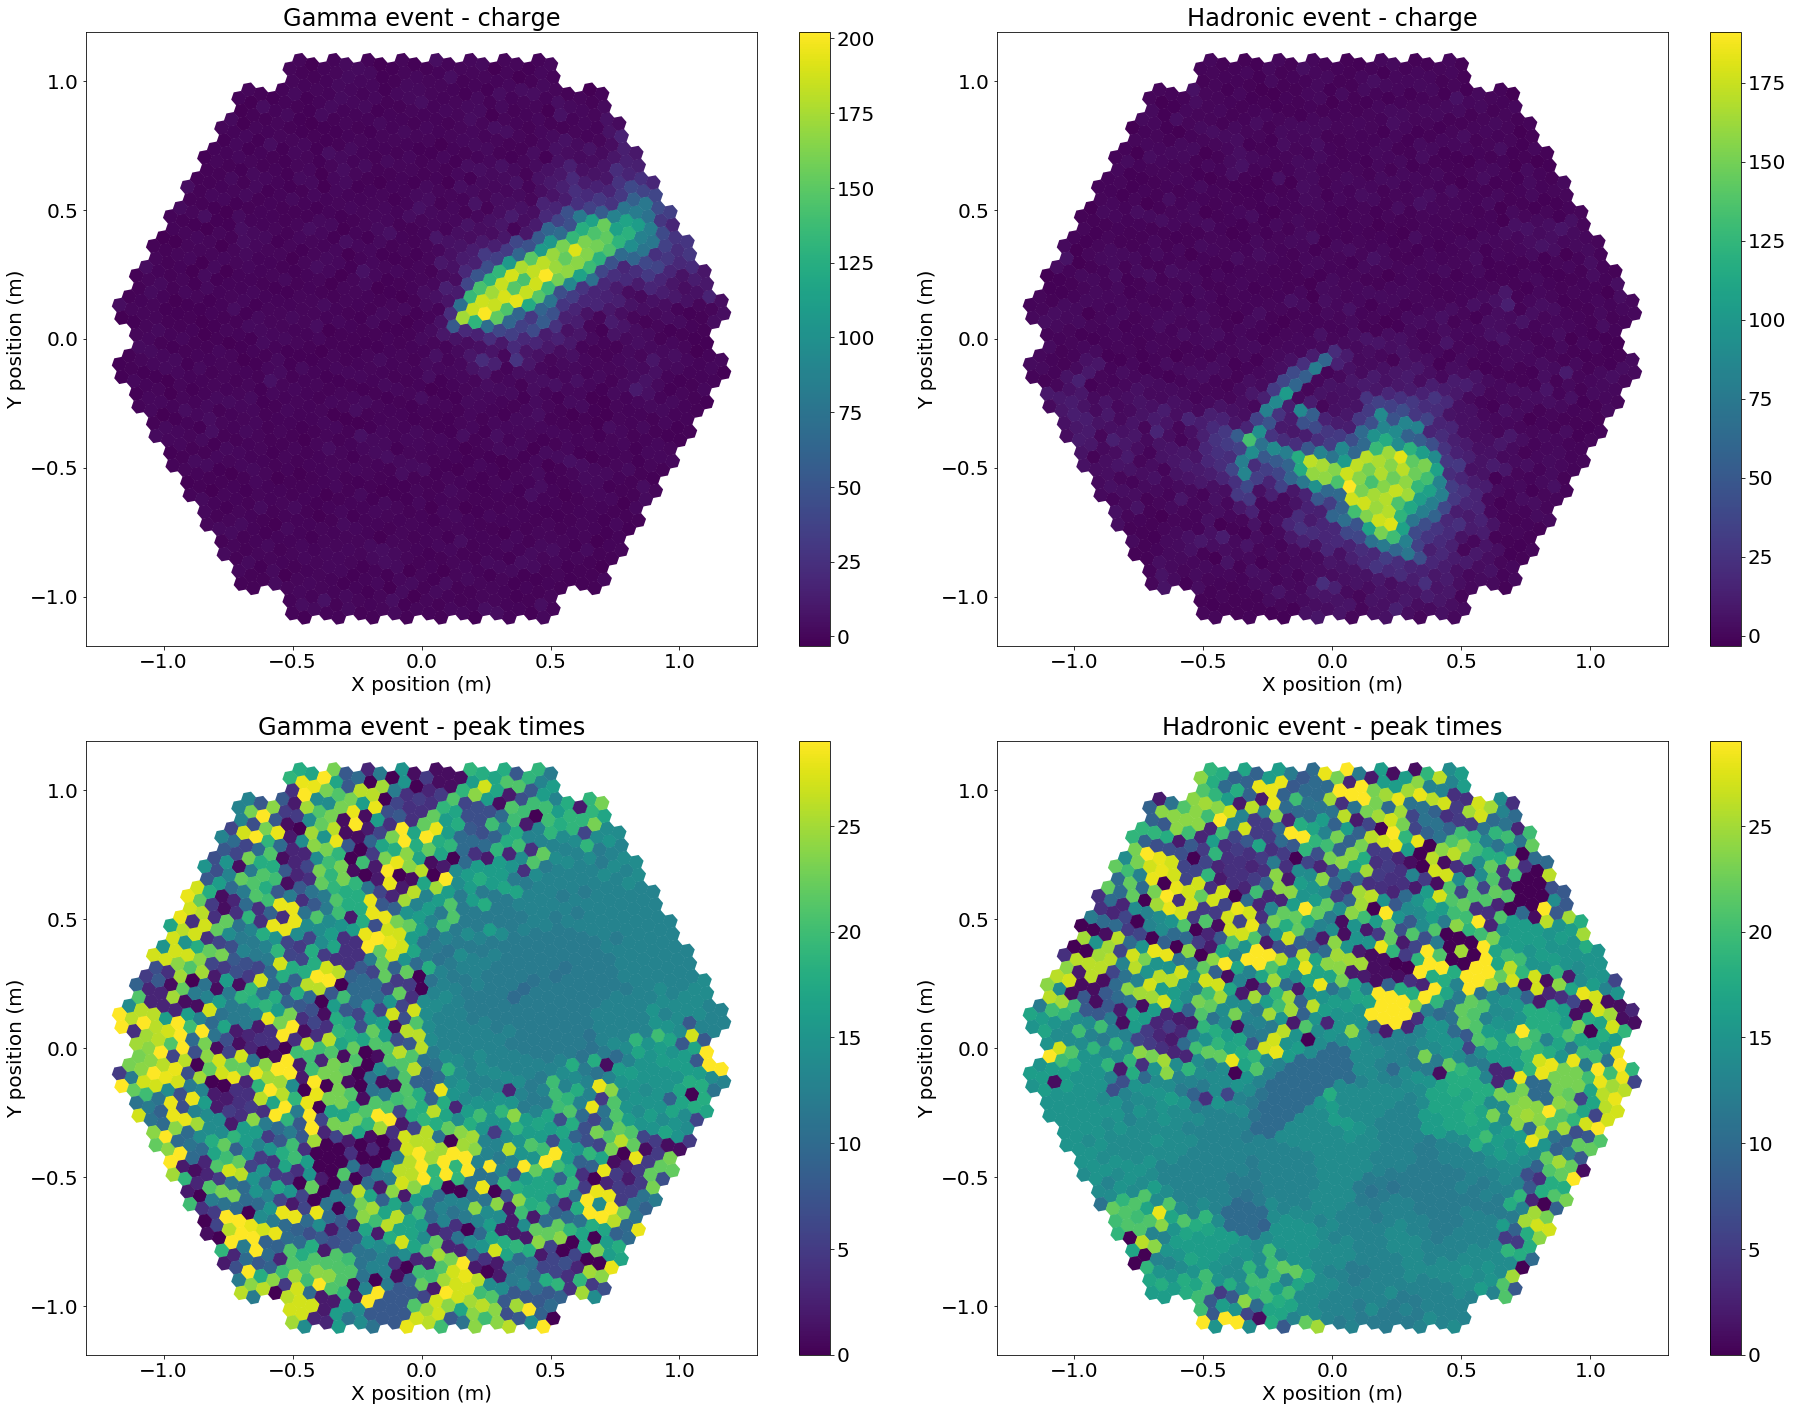

In [20]:
# Load the camera
geom = CameraGeometry.from_name("LSTCam")

f = 2
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proton

ax = plt.subplot(2, 2, 3)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - peak times")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 2, 4)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - peak times")
disp.add_colorbar()
disp.image = img_time_proton

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0, transparent=True)

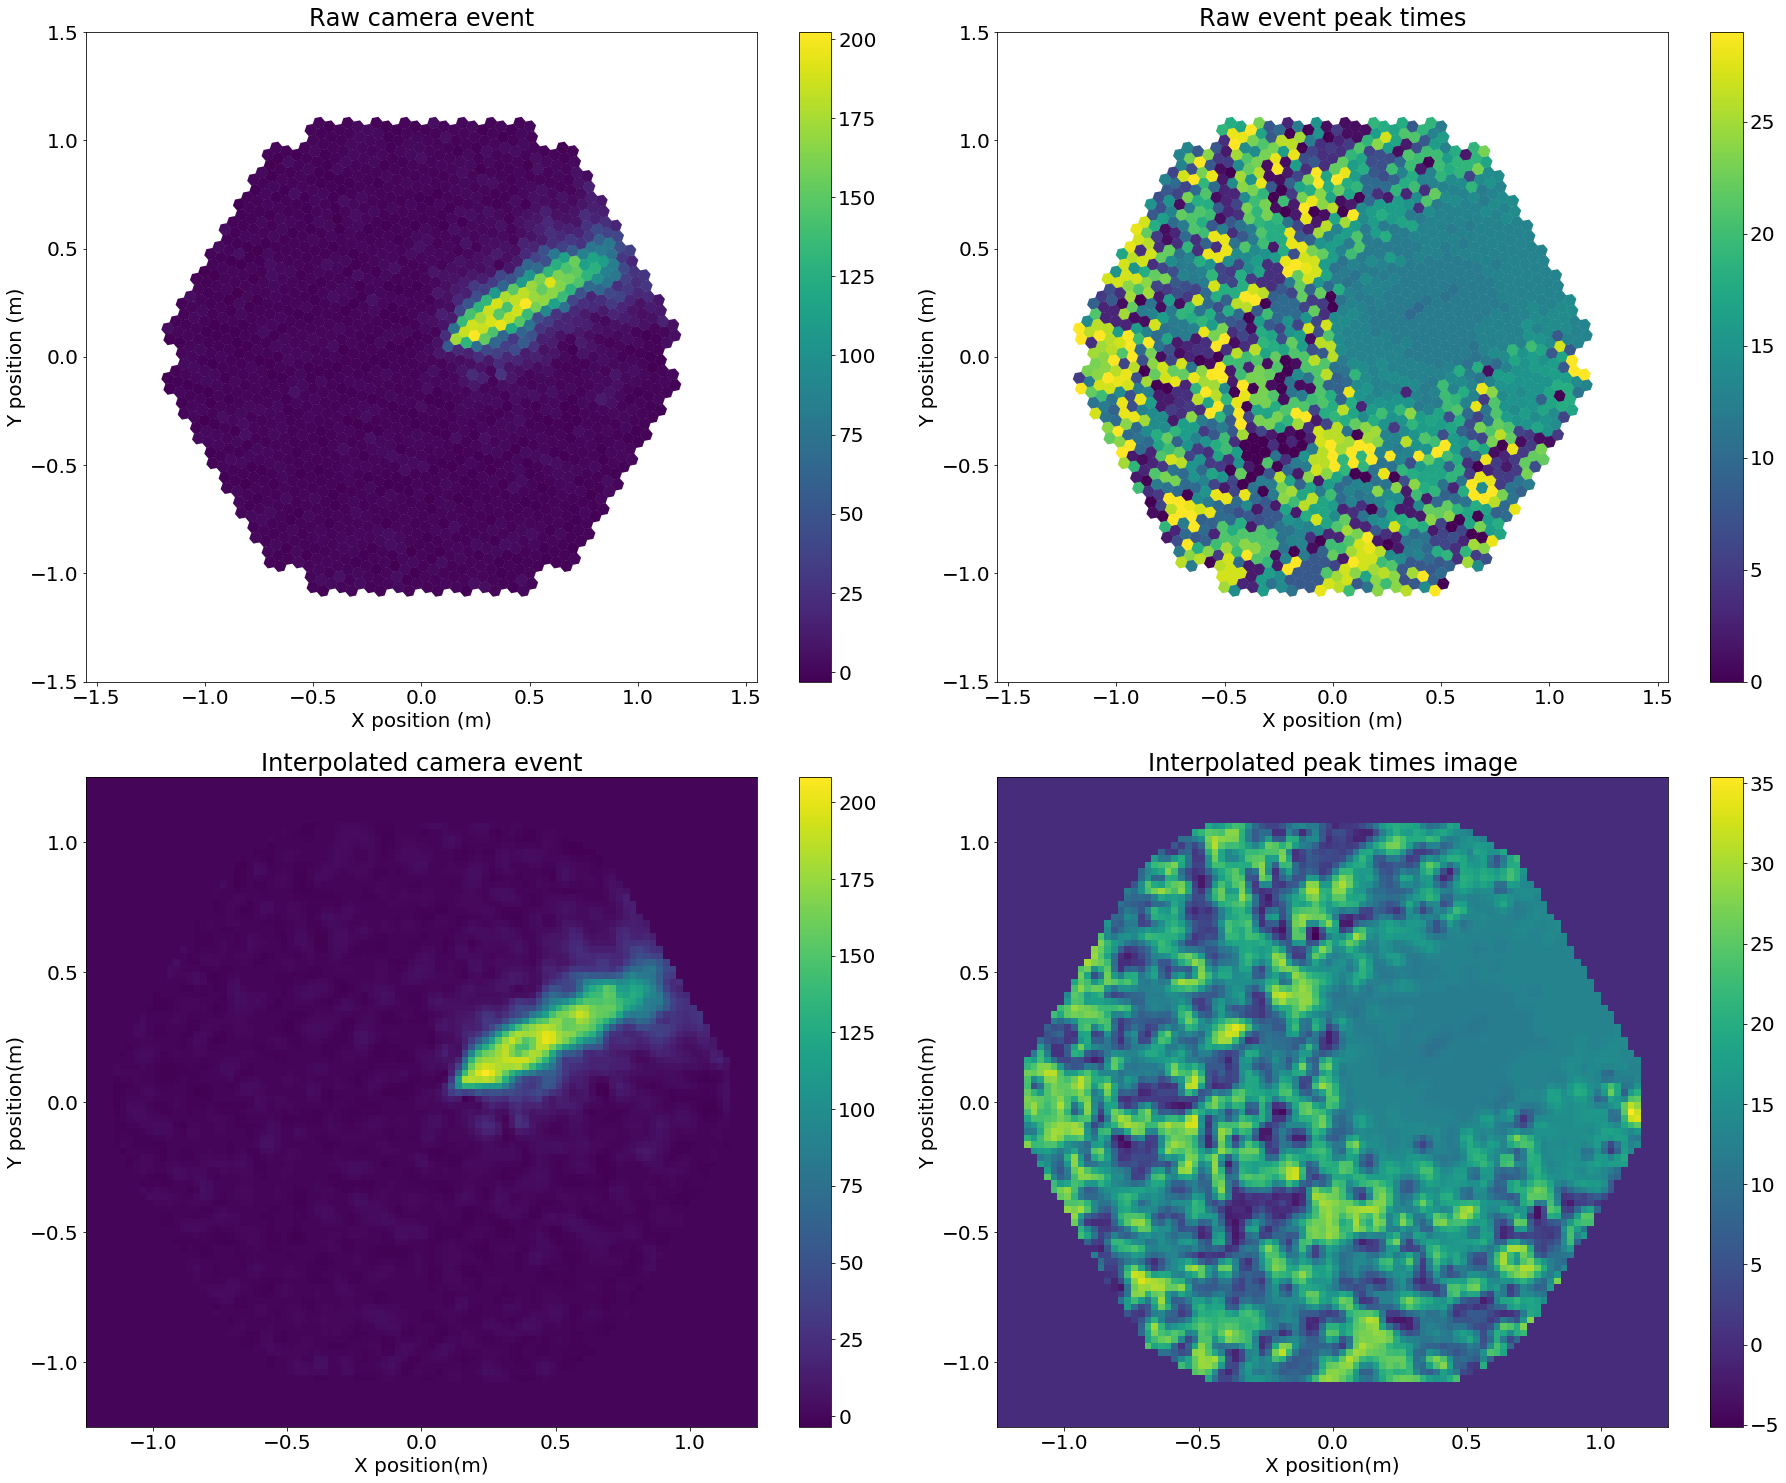

In [104]:
%matplotlib inline 
import matplotlib
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(26, 21))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 2, 3)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge_gamma)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated camera event')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Raw event peak times")
disp.add_colorbar()
disp.image = img_time_gamma


ax = plt.subplot(2, 2, 4)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time_gamma)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated peak times image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


plt.tight_layout()
plt.savefig('real-interp-4.eps', format='eps', bbox_inches='tight', pad_inches=0)